In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap

from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

/anaconda3/envs/mlpy36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
TRAIN_PATH = "/Users/zakopuro/Code/python_code/kaggle_TMDB/input/train.csv"
TEST_PATH = "/Users/zakopuro/Code/python_code/kaggle_TMDB/input/test.csv"

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

df_train = text_to_dict(df_train)
df_test = text_to_dict(df_test)

In [3]:
df_train.head()

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                 {}   3300000   
3   4                                                 {}   1200000   
4   5                                                 {}         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   
2  [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3                                                 {}   
4                                                 {}   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...     10/10/14    105.0   
3            [{'iso_3166_1': 'IN', 'name': 'India'}]       3/9/12    122.0   
4      [{'iso_3166_1': 'KR', 'name': 'South Korea'}]       2/5/09    118.0   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
4           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name':

In [4]:
df_test.head()

id                              belongs_to_collection   budget  \
0  3001  [{'id': 34055, 'name': 'Pokémon Collection', '...        0   
1  3002                                                 {}    88000   
2  3003                                                 {}        0   
3  3004                                                 {}  6800000   
4  3005                                                 {}  2000000   

                                              genres  \
0  [{'id': 12, 'name': 'Adventure'}, {'id': 16, '...   
1  [{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...   
2  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
3  [{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...   
4  [{'id': 36, 'name': 'History'}, {'id': 99, 'na...   

                                            homepage    imdb_id  \
0  http://www.pokemon.com/us/movies/movie-pokemon...  tt1226251   
1                                                NaN  tt0051380   
2                                                NaN  tt0118556   
3             http://www.sonyclassics.com/incendies/  tt1255953   
4                                                NaN  tt0418753   

  original_language               original_title  \
0                ja           ディアルガVSパルキアVSダークライ   
1                en  Attack of the 50 Foot Woman   
2                en             Addicted to Love   
3                fr                    Incendies   
4                en           Inside Deep Throat   

                                            overview  popularity  \
0  Ash and friends (this time accompanied by newc...    3.851534   
1  When an abused wife grows to giant size becaus...    3.559789   
2  Good-natured astronomer Sam is devastated when...    8.085194   
3  A mother's last wishes send twins Jeanne and S...    8.596012   
4  In 1972, a seemingly typical shoestring budget...    3.217680   

                        poster_path  \
0  /tnftmLMemPLduW6MRyZE0ZUD19z.jpg   
1  /9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg   
2  /ed6nD7h9sbojSWY2qrnDcSvDFko.jpg   
3  /sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg   
4  /n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg   

                                production_companies  \
0                                                 {}   
1  [{'name': 'Woolner Brothers Pictures Inc.', 'i...   
2  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...   
3  [{'name': 'TS Productions', 'id': 313}, {'name...   
4                                                 {}   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...      7/14/07     90.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...      5/19/58     65.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...      5/23/97    100.0   
3  [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...       9/4/10    130.0   
4  [{'iso_3166_1': 'US', 'name': 'United States o...      2/11/05     92.0   

                                    spoken_languages    status  \
0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'fr', 'name': 'Français'}, {'is...  Released   
4           [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0  Somewhere Between Time & Space... A Legend Is ...   
1  A titanic beauty spreads a macabre wave of hor...   
2          A Comedy About Lost Loves And Last Laughs   
3  The search began at the opening of their mothe...   
4  It was filmed in 6 days for 25 thousand dollar...   

                          title  \
0  Pokémon: The Rise of Darkrai   
1   Attack of the 50 Foot Woman   
2              Addicted to Love   
3                     Incendies   
4            Inside Deep Throat   

                                            Keywords  \
0  [{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...   
1  [{'id': 9748, '

In [5]:
df_train.shape,df_test.shape

((3000, 23), (4398, 22))

In [6]:
for i, e in enumerate(df_train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [7]:
df_train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [8]:
df_train['collection_name'] = df_train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
df_train['has_collection'] = df_train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

df_test['collection_name'] = df_test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
df_test['has_collection'] = df_test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

df_train = df_train.drop(['belongs_to_collection'], axis=1)
df_test = df_test.drop(['belongs_to_collection'], axis=1)

In [9]:
df_train.head()

id    budget                                             genres  \
0   1  14000000                     [{'id': 35, 'name': 'Comedy'}]   
1   2  40000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2   3   3300000                      [{'id': 18, 'name': 'Drama'}]   
3   4   1200000  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4   5         0  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   
2  [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3                                                 {}   
4                                                 {}   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...     10/10/14    105.0   
3            [{'iso_3166_1': 'IN', 'name': 'India'}]       3/9/12    122.0   
4      [{'iso_3166_1': 'KR', 'name': 'South Korea'}]       2/5/09    118.0   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
4           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 10092, 'name': 'mystery'}, {'id': 1054...   
4                                                 {}   

                                                cast  \
0  [{'cast_id': 4, 'char

In [10]:
df_test.head()

id   budget                                             genres  \
0  3001        0  [{'id': 12, 'name': 'Adventure'}, {'id': 16, '...   
1  3002    88000  [{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...   
2  3003        0  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
3  3004  6800000  [{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...   
4  3005  2000000  [{'id': 36, 'name': 'History'}, {'id': 99, 'na...   

                                            homepage    imdb_id  \
0  http://www.pokemon.com/us/movies/movie-pokemon...  tt1226251   
1                                                NaN  tt0051380   
2                                                NaN  tt0118556   
3             http://www.sonyclassics.com/incendies/  tt1255953   
4                                                NaN  tt0418753   

  original_language               original_title  \
0                ja           ディアルガVSパルキアVSダークライ   
1                en  Attack of the 50 Foot Woman   
2                en             Addicted to Love   
3                fr                    Incendies   
4                en           Inside Deep Throat   

                                            overview  popularity  \
0  Ash and friends (this time accompanied by newc...    3.851534   
1  When an abused wife grows to giant size becaus...    3.559789   
2  Good-natured astronomer Sam is devastated when...    8.085194   
3  A mother's last wishes send twins Jeanne and S...    8.596012   
4  In 1972, a seemingly typical shoestring budget...    3.217680   

                        poster_path  \
0  /tnftmLMemPLduW6MRyZE0ZUD19z.jpg   
1  /9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg   
2  /ed6nD7h9sbojSWY2qrnDcSvDFko.jpg   
3  /sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg   
4  /n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg   

                                production_companies  \
0                                                 {}   
1  [{'name': 'Woolner Brothers Pictures Inc.', 'i...   
2  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...   
3  [{'name': 'TS Productions', 'id': 313}, {'name...   
4                                                 {}   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...      7/14/07     90.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...      5/19/58     65.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...      5/23/97    100.0   
3  [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...       9/4/10    130.0   
4  [{'iso_3166_1': 'US', 'name': 'United States o...      2/11/05     92.0   

                                    spoken_languages    status  \
0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'fr', 'name': 'Français'}, {'is...  Released   
4           [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0  Somewhere Between Time & Space... A Legend Is ...   
1  A titanic beauty spreads a macabre wave of hor...   
2          A Comedy About Lost Loves And Last Laughs   
3  The search began at the opening of their mothe...   
4  It was filmed in 6 days for 25 thousand dollar...   

                          title  \
0  Pokémon: The Rise of Darkrai   
1   Attack of the 50 Foot Woman   
2              Addicted to Love   
3                     Incendies   
4            Inside Deep Throat   

                                            Keywords  \
0  [{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...   
1  [{'id': 9748, 'name': 'revenge'}, {'id': 9951,...   
2  [{'id': 931, 'name': 'jealousy'}, {'id': 9673,...   
3  [{'id': 378, 'name': 'prison'}, {'id': 539, 'n...   
4  [{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...   

                                                cast  \
0  [{'cast_id': 3, 'character': 'Tonio', 'credit_...   
1  [{'cast_id': 2,

In [11]:
for i,e in enumerate(df_train['genres'][:5]):
    print(i,e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [12]:
df_train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [13]:
list_of_genres = list(df_train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

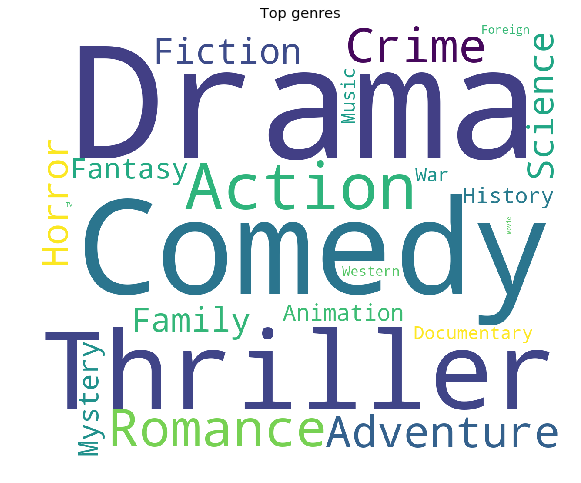

In [14]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

In [15]:
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

In [16]:
df_train['num_genres'] = df_train['genres'].apply(lambda x: len(x) if x != {} else 0)
df_train['all_genres'] = df_train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    df_train['genre_' + g] = df_train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
df_test['num_genres'] = df_test['genres'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_genres'] = df_test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    df_test['genre_' + g] = df_test['all_genres'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['genres'], axis=1)
df_test = df_test.drop(['genres'], axis=1)

In [17]:
for i, e in enumerate(df_train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [18]:
df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

In [19]:
df_train[df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0) > 11]

id    budget                                           homepage  \
31      32         0                        http://www.cache-derfilm.at   
116    117         0                                                NaN   
363    364  15400000                                                NaN   
392    393         0                                                NaN   
449    450  80000000             http://asoundofthunder.warnerbros.com/   
554    555  14500000                                                NaN   
1079  1080   7000000                                                NaN   
2170  2171   4000000  http://tickets.picturehouseentertainment.co.uk...   
2395  2396         0                                                NaN   
2517  2518  97250400  http://www.asterixauxjeuxolympiques.com/index.php   

        imdb_id original_language               original_title  \
31    tt0387898                fr                        Caché   
116   tt2113822                zh                         一九四二   
363   tt2053425                fr           De rouille et d'os   
392   tt5072406                fr                         Moka   
449   tt0318081                en           A Sound of Thunder   
554   tt0293416                ja                   Metropolis   
1079  tt2737050                fr         Deux jours, une nuit   
2170  tt3464902                en                  The Lobster   
2395  tt4082068                fr                      Dheepan   
2517  tt0463872                fr  Astérix aux Jeux Olympiques   

                                               overview  popularity  \
31    A married couple is terrorized by a series of ...    5.695860   
116   In 1942, Henan Province was devastated by the ...    1.678013   
363   Put in charge of his young son, Ali leaves Bel...    8.400049   
392   Diane Kramer is led by one obsession: to find ...    2.404466   
449   When a hunter sent back to the prehistoric era...    4.980191   
554   Duke Red has overseen the construction of a ma...    9.298092   
1079  Sandra is a young woman who has only one weeke...    6.868022   
2170  In a dystopian near future, single people, acc...   11.223033   
2395  Dheepan is a Sri Lankan Tamil warrior who flee...    5.752416   
2517  Ast√©rix and Ob√©lix have to win the Olympic G...    9.671944   

                           poster_path  \
31    /i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg   
116    /xxz2gi8vijqqJySGO3kQy2i8mv.jpg   
363   /cHCwW8xPl8yPKQwpNzKVinwvirT.jpg   
392   /5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg   
449   /gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg   
554   /1EK7mGCpRKYmSg25FaojvnS9opm.jpg   
1079  /1mYAejpMskvskGr0J0SaBvdjmrH.jpg   
2170  /yR60EqMGS9hHq9I5Pkq2hG984TP.jpg   
2395  /lgONuekbRlM0eMvMHJBEDL6MsBP.jpg   
2517  /tKL0RJOeuccc1rrpcDKg8qhedIz.jpg   

                                   production_companies  \
31    [{'name': 'Les Films du Losange', 'id': 223}, ...   
116   [{'name': 'Emperor Motion Pictures', 'id': 272...   
363   [{'name': 'France 2 Cinéma', 'id': 83}, {'name...   
392   [{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...   
449   [{'name': 'Epsilon Motion Pictures', 'id': 117...   
554   [{'name': 'Bandai Visual Company', 'id': 528},...   
1079  [{'name': 'BIM Distribuzione', 'id': 225}, {'n...   
2170  [{'name': 'Haut et Court', 'id': 726}, {'name'...   
2395  [{'name': 'France 2 Cinéma', 'id': 83}, {'name...   
2517  [{'name': 'Constantin Film', 'id': 47}, {'name...   

                                   production_countries release_date  runtime  \
31    [{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...       5/2/05    117.0   
116             [{'iso_3166_1': 'CN', 'name': 'China'}]      11/1/12    145.0   
363   [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...      5/17/12    123.0   
392   [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...      8/17/16     89.0   
449   [{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...      5/15/05    110.0   
554             [{'iso_3166_1': 'JP', 'name': 'Japan'}]      5/26/01    10

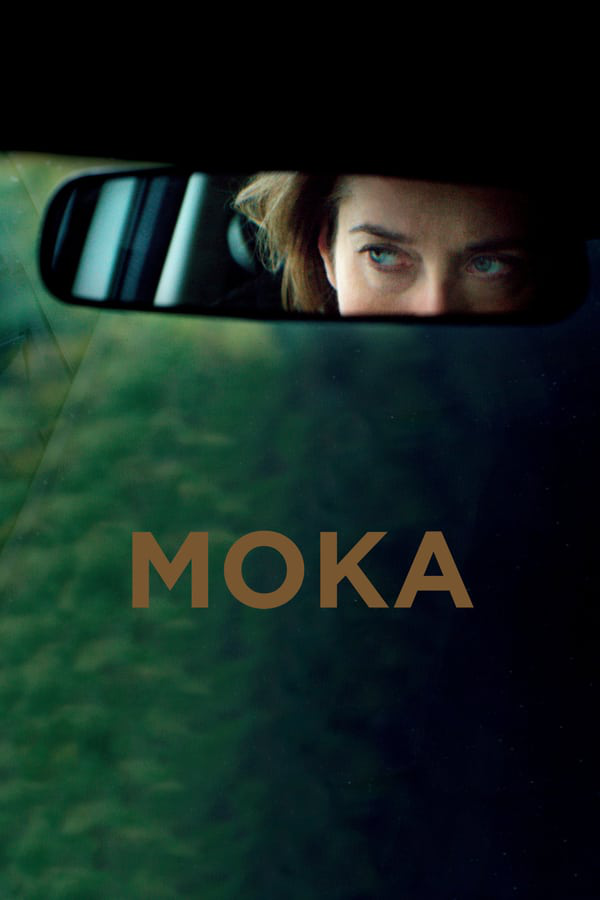

In [20]:
img = Image.open(urlopen("https://image.tmdb.org/t/p/w600_and_h900_bestv2/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg"))
img

In [21]:
list_of_companies = list(df_train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [22]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

In [23]:
df_train['num_companies'] = df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df_train['all_production_companies'] = df_train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    df_train['production_company_' + g] = df_train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
df_test['num_companies'] = df_test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_production_companies'] = df_test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    df_test['production_company_' + g] = df_test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['production_companies', 'all_production_companies'], axis=1)
df_test = df_test.drop(['production_companies', 'all_production_companies'], axis=1)

In [24]:
df_train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...     10/10/14    105.0   
3            [{'iso_3166_1': 'IN', 'name': 'India'}]       3/9/12    122.0   
4      [{'iso_3166_1': 'KR', 'name': 'South Korea'}]       2/5/09    118.0   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
4           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 10092, 'name': 'mystery'}, {'id': 1054...   
4                                                 {}   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000   
3  [{'credit_id': '52fe48779251416c9108d6eb', 'de...  16000000   
4  [{'credit_id': '52fe464b9251416c75073b43', 'de...   3923970   

                   c

In [25]:
for i, e in enumerate(df_train['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [26]:
df_train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

In [27]:
list_of_countries = list(df_train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

In [28]:
df_train['num_countries'] = df_train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
df_train['all_countries'] = df_train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    df_train['production_country_' + g] = df_train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
df_test['num_countries'] = df_test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_countries'] = df_test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    df_test['production_country_' + g] = df_test['all_countries'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['production_countries', 'all_countries'], axis=1)
df_test = df_test.drop(['production_countries', 'all_countries'], axis=1)

In [29]:
df_train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path release_date  runtime  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
4           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 10092, 'name': 'mystery'}, {'id': 1054...   
4                                                 {}   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000   
3  [{'credit_id': '52fe48779251416c9108d6eb', 'de...  16000000   
4  [{'credit_id': '52fe464b9251416c75073b43', 'de...   3923970   

                   collection_name  has_collection  num_genres  \
0  Hot Tub Time Machine Collection               1           1   
1  The Princess Diaries Collection               1           4   
2                                0               0           1   
3                                0               0           2   
4                          

In [30]:
for i, e in enumerate(df_train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [31]:
print('Number of spoken languages in films')
df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [32]:
list_of_languages = list(df_train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [33]:
df_train['num_languages'] = df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df_train['all_languages'] = df_train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    df_train['language_' + g] = df_train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
df_test['num_languages'] = df_test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_languages'] = df_test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    df_test['language_' + g] = df_test['all_languages'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['spoken_languages', 'all_languages'], axis=1)
df_test = df_test.drop(['spoken_languages', 'all_languages'], axis=1)

In [34]:
for i, e in enumerate(df_train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [35]:
df_train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

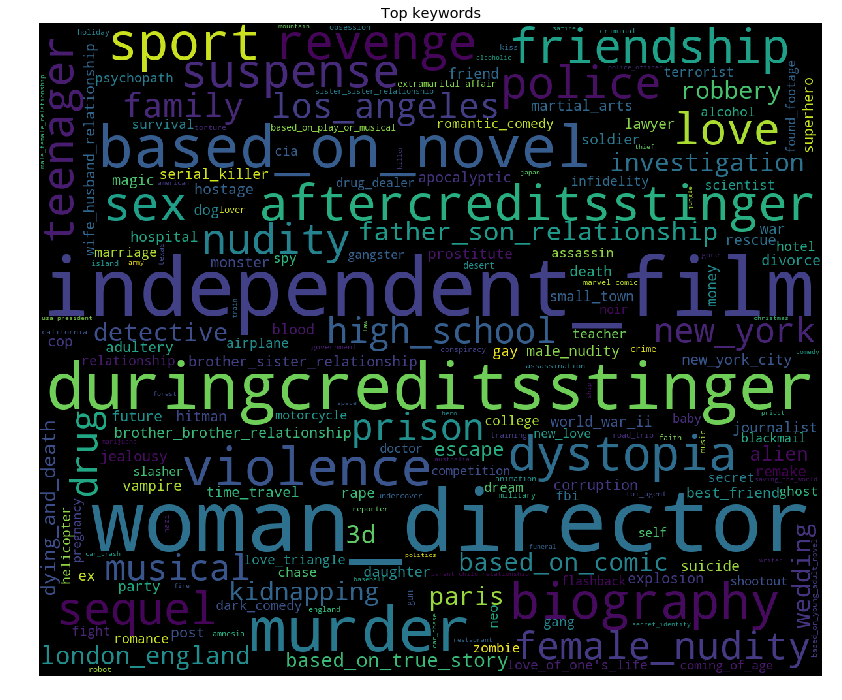

In [36]:
list_of_keywords = list(df_train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

In [37]:
df_train['num_Keywords'] = df_train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
df_train['all_Keywords'] = df_train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    df_train['keyword_' + g] = df_train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
df_test['num_Keywords'] = df_test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_Keywords'] = df_test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    df_test['keyword_' + g] = df_test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['Keywords', 'all_Keywords'], axis=1)
df_test = df_test.drop(['Keywords', 'all_Keywords'], axis=1)

In [38]:
df_train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path release_date  runtime    status  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000   
3  [{'credit_id': '52fe48779251416c9108d6eb', 'de...  16000000   
4  [{'credit_id': '52fe464b9251416c75073b43', 'de...   3923970   

                   collection_name  has_collection  num_genres  \
0  Hot Tub Time Machine Collection               1           1   
1  The Princess Diaries Collection               1           4   
2                                0               0           1   
3                                0               0           2   
4                                0               0           2   

                    all_genres  genre_Drama  genre_Comedy  genre_Thriller  \
0                       Comedy            0             1               0   
1  Comedy Drama Family Romance            1             1               0   
2                        Drama            1             0               0   
3               Drama Thriller            1             0               1   
4              Action Thriller            0             0               1   

   genre_Action  genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
0             0              0            0                0             0   
1             0

In [39]:
for i, e in enumerate(df_train['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [40]:
df_train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

In [41]:
list_of_cast_names = list(df_train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

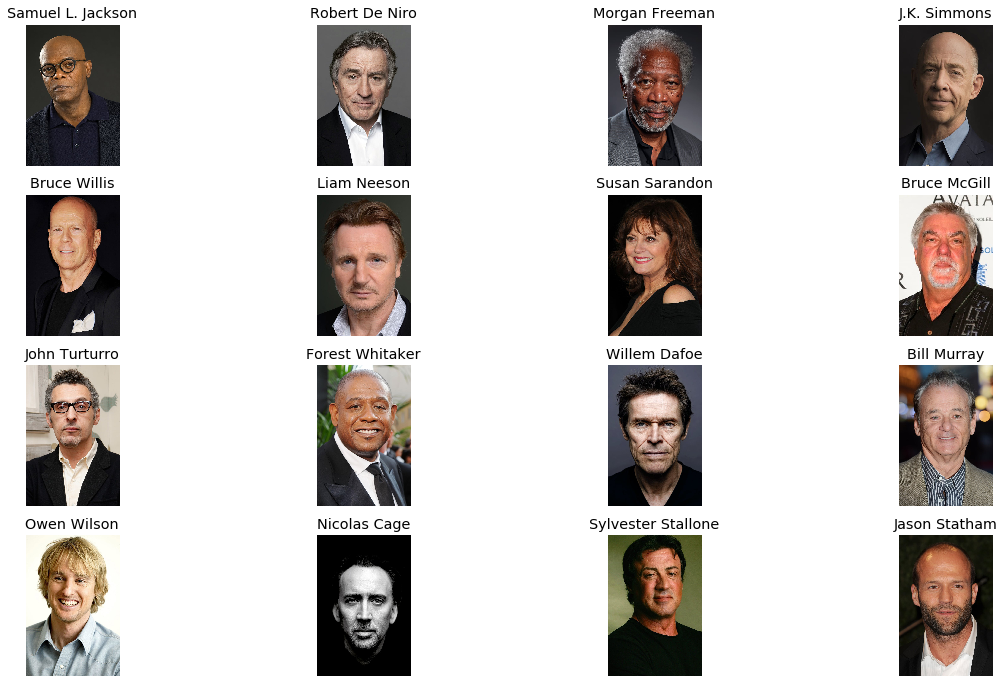

In [42]:
list_of_cast_names_url = list(df_train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 12))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    plt.imshow(im)
    ax.set_title(f'{p[0]}')

In [43]:
list_of_cast_genders = list(df_train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

In [44]:
list_of_cast_characters = list(df_train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

In [45]:
df_train['num_cast'] = df_train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    df_train['cast_name_' + g] = df_train['cast'].apply(lambda x: 1 if g in str(x) else 0)
df_train['genders_0_cast'] = df_train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_train['genders_1_cast'] = df_train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_train['genders_2_cast'] = df_train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    df_train['cast_character_' + g] = df_train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
df_test['num_cast'] = df_test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    df_test['cast_name_' + g] = df_test['cast'].apply(lambda x: 1 if g in str(x) else 0)
df_test['genders_0_cast'] = df_test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_test['genders_1_cast'] = df_test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_test['genders_2_cast'] = df_test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    df_test['cast_character_' + g] = df_test['cast'].apply(lambda x: 1 if g in str(x) else 0)

df_train = df_train.drop(['cast'], axis=1)
df_test = df_test.drop(['cast'], axis=1)

In [46]:
for i, e in enumerate(df_train['crew'][:1]):
    print(i, e[:10])

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [47]:
df_train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: crew, dtype: int64

In [48]:
list_of_crew_names = list(df_train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [49]:
list_of_crew_jobs = list(df_train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [50]:
list_of_crew_genders = list(df_train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [51]:
list_of_crew_departments = list(df_train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [54]:
df_train['num_crew'] = df_train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    df_train['crew_name_' + g] = df_train['crew'].apply(lambda x: 1 if g in str(x) else 0)
df_train['genders_0_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_train['genders_1_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_train['genders_2_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    df_train['crew_character_' + g] = df_train['crew'].apply(lambda x: 1 if g in str(x) else 0)
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    df_train['jobs_' + j] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    df_train['departments_' + j] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
df_test['num_crew'] = df_test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    df_test['crew_name_' + g] = df_test['crew'].apply(lambda x: 1 if g in str(x) else 0)
df_test['genders_0_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_test['genders_1_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_test['genders_2_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    df_test['crew_character_' + g] = df_test['crew'].apply(lambda x: 1 if g in str(x) else 0)
for j in top_crew_jobs:
    df_test['jobs_' + j] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    df_test['departments_' + j] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

df_train = df_train.drop(['crew'], axis=1)
df_test = df_test.drop(['crew'], axis=1)

In [55]:
df_train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path release_date  runtime    status  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title   revenue  \
0                    Hot Tub Time Machine 2  12314651   
1  The Princess Diaries 2: Royal Engagement  95149435   
2                                  Whiplash  13092000   
3                                   Kahaani  16000000   
4                                Marine Boy   3923970   

                   collection_name  has_collection  num_genres  \
0  Hot Tub Time Machine Collection               1           1   
1  The Princess Diaries Collection               1           4   
2                                0               0           1   
3                                0               0           2   
4                                0               0           2   

                    all_genres  genre_Drama  genre_Comedy  genre_Thriller  \
0                       Comedy            0             1               0   
1  Comedy Drama Family Romance            1             1               0   
2                        Drama            1             0               0   
3               Drama Thriller            1             0               1   
4              Action Thriller            0             0               1   

   genre_Action  genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
0             0              0            0                0             0   
1             0              1            0                0             0   
2             0              0            0                0             0   
3             0              0            0                0             0   
4             1              0            0                0             0   

   genre_Science Fiction  genre_Family  genre_Fantasy  genre_Mystery  \
0                      0             0              0              0   
1                      0             1              0              0   
2                      0             0              0              0   
3                      0             0              0              0   
4               

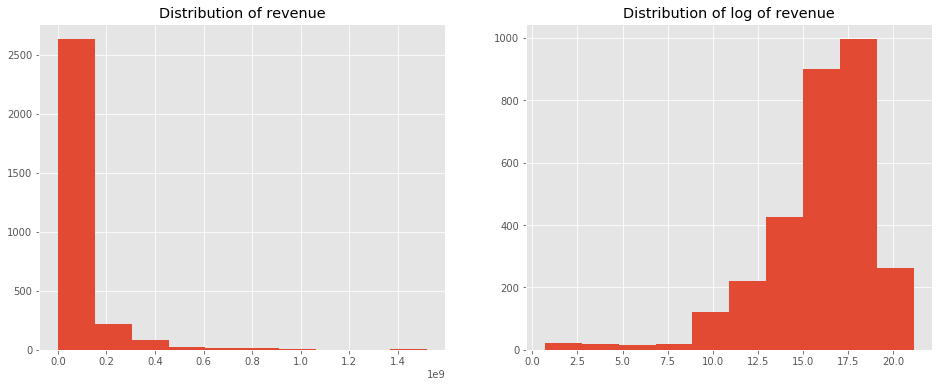

In [57]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(df_train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_train['revenue']));
plt.title('Distribution of log of revenue');

In [58]:
df_train['log_revenue'] = np.log1p(df_train['revenue'])

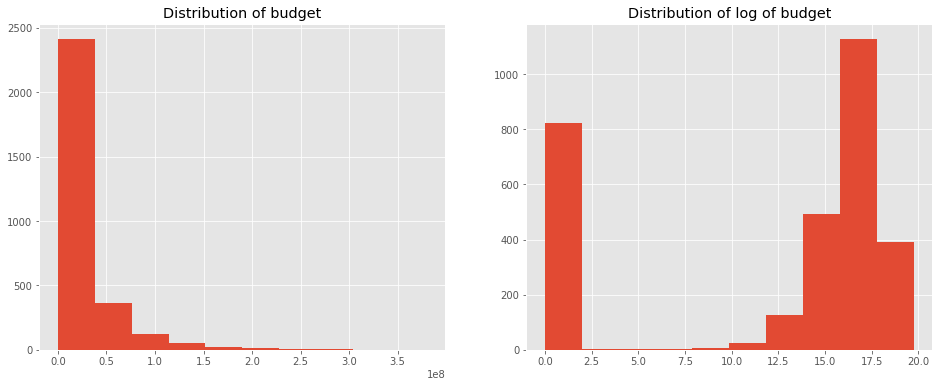

In [59]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(df_train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_train['budget']));
plt.title('Distribution of log of budget');

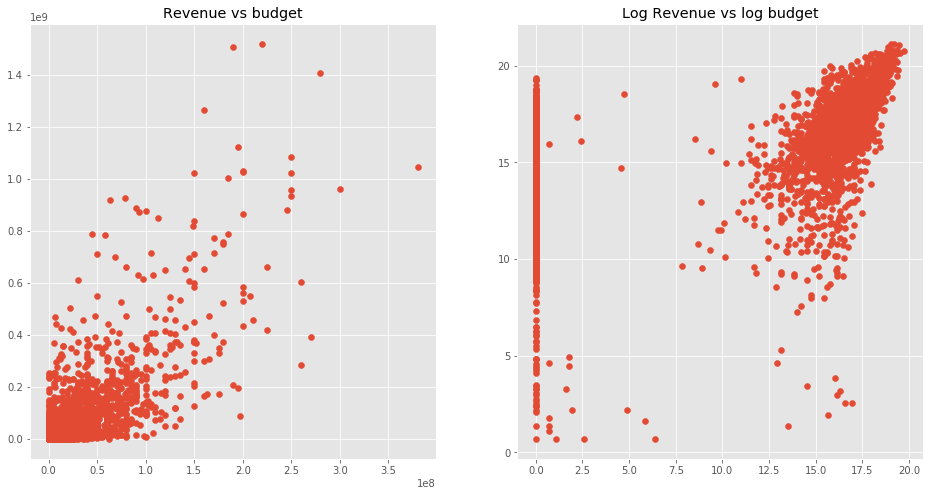

In [60]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(df_train['budget'], df_train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(df_train['budget']), df_train['log_revenue'])
plt.title('Log Revenue vs log budget');

In [61]:
df_train['log_budget'] = np.log1p(df_train['budget'])
df_test['log_budget'] = np.log1p(df_test['budget'])

In [62]:
df_train['homepage'].value_counts().head()

http://www.transformersmovie.com/        4
http://www.lordoftherings.net/           2
http://www.thehobbit.com/                2
http://www.lostcityofzfilm.co.uk/home    1
http://www.morganalapelicula.com/        1
Name: homepage, dtype: int64

In [64]:
df_train['has_homepage'] = 0
df_train.loc[df_train['homepage'].isnull() == False, 'has_homepage'] = 1
df_test['has_homepage'] = 0
df_test.loc[df_test['homepage'].isnull() == False, 'has_homepage'] = 1

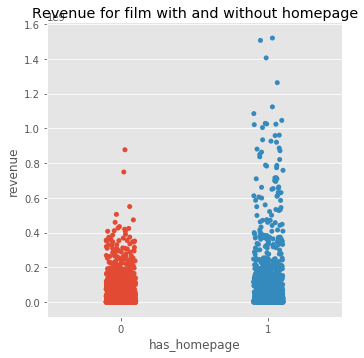

In [66]:
sns.catplot(x='has_homepage', y='revenue', data=df_train);
plt.title('Revenue for film with and without homepage');

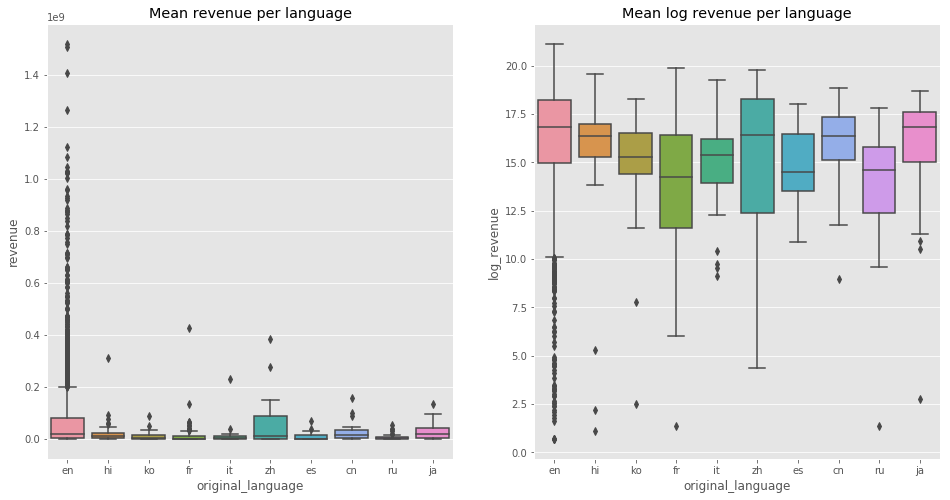

In [67]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=df_train.loc[df_train['original_language'].isin(df_train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=df_train.loc[df_train['original_language'].isin(df_train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

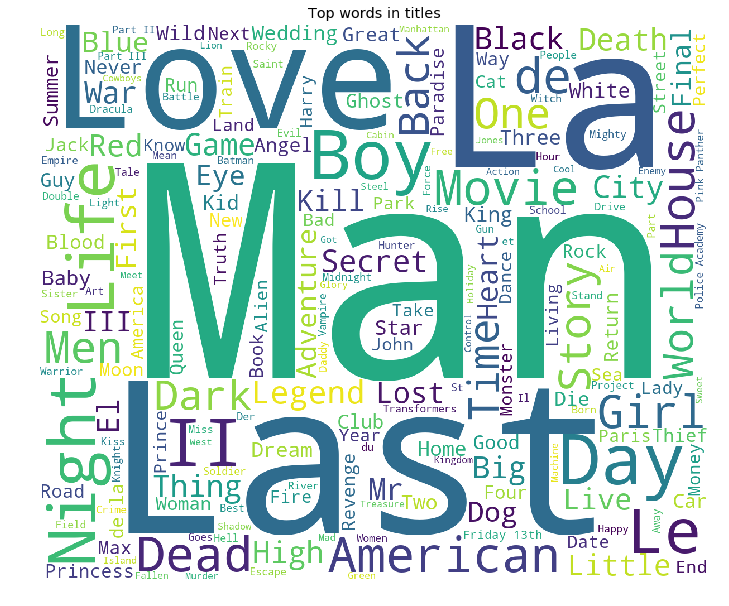

In [68]:
plt.figure(figsize = (12, 12))
text = ' '.join(df_train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

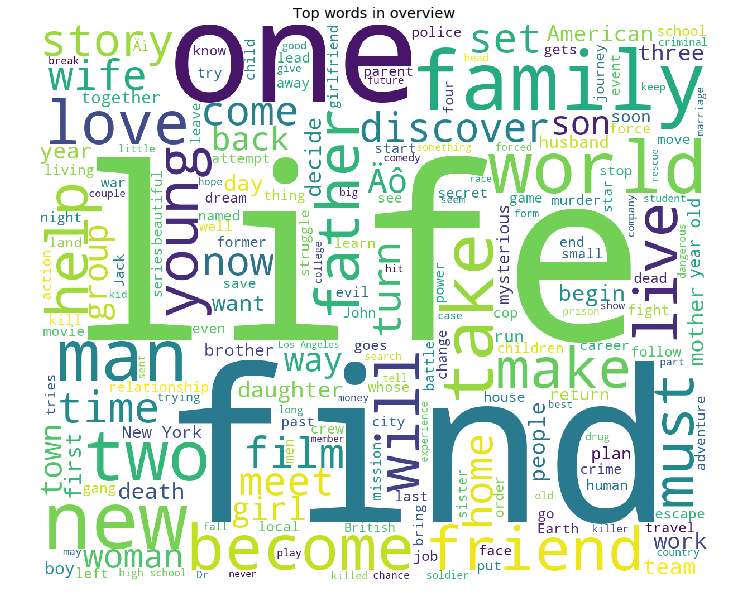

In [69]:
plt.figure(figsize = (12, 12))
text = ' '.join(df_train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

In [70]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(df_train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, df_train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [71]:
eli5.show_prediction(linreg, doc=df_train['overview'].values[1000], vec=vectorizer)

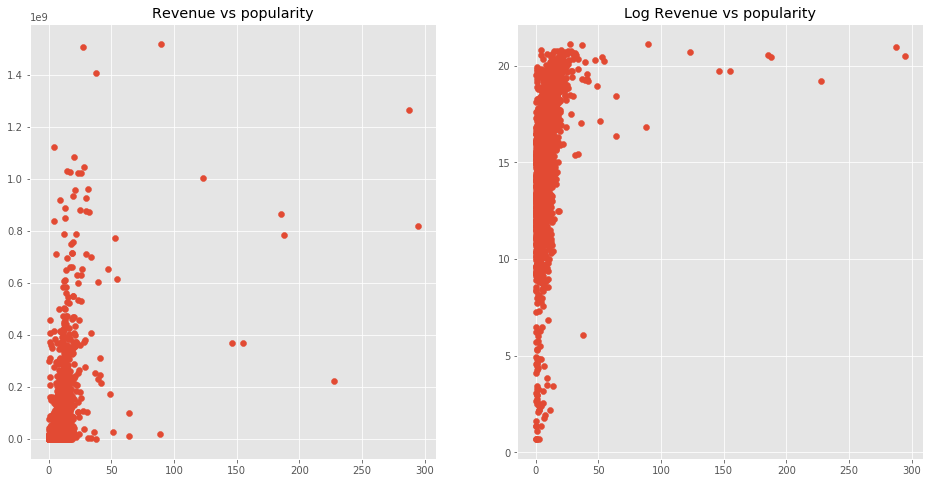

In [72]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(df_train['popularity'], df_train['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(df_train['popularity'], df_train['log_revenue'])
plt.title('Log Revenue vs popularity');

In [74]:
df_test.loc[df_test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [75]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [76]:
df_train['release_date'] = df_train['release_date'].apply(lambda x: fix_date(x))
df_test['release_date'] = df_test['release_date'].apply(lambda x: fix_date(x))
df_train['release_date'] = pd.to_datetime(df_train['release_date'])
df_test['release_date'] = pd.to_datetime(df_test['release_date'])


In [77]:
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

df_train = process_date(df_train)
df_test = process_date(df_test)

In [78]:
d1 = df_train['release_date_year'].value_counts().sort_index()
d2 = df_test['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [79]:
d1 = df_train['release_date_year'].value_counts().sort_index()
d2 = df_train.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [80]:
d1 = df_train['release_date_year'].value_counts().sort_index()
d2 = df_train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

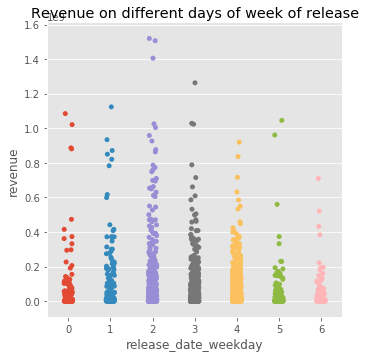

In [81]:
sns.catplot(x='release_date_weekday', y='revenue', data=df_train);
plt.title('Revenue on different days of week of release');

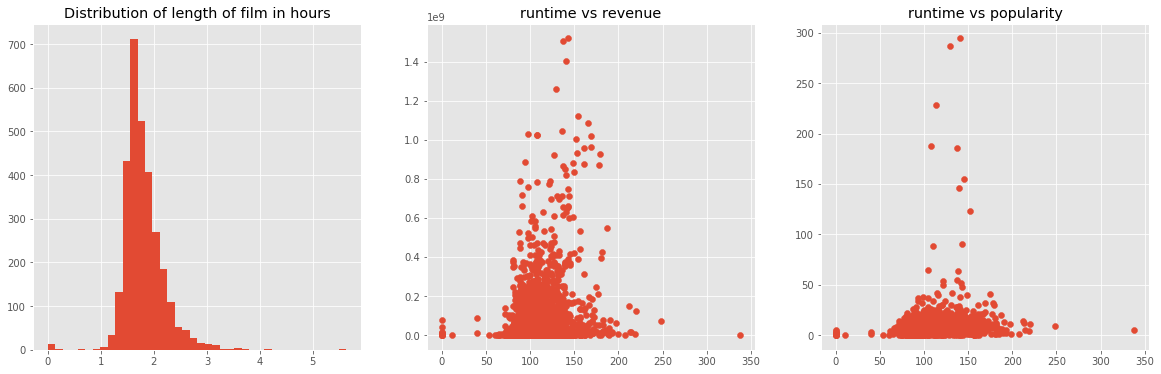

In [82]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(df_train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(df_train['runtime'].fillna(0), df_train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(df_train['runtime'].fillna(0), df_train['popularity'])
plt.title('runtime vs popularity');

In [83]:
df_train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [84]:
df_test['status'].value_counts()


Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

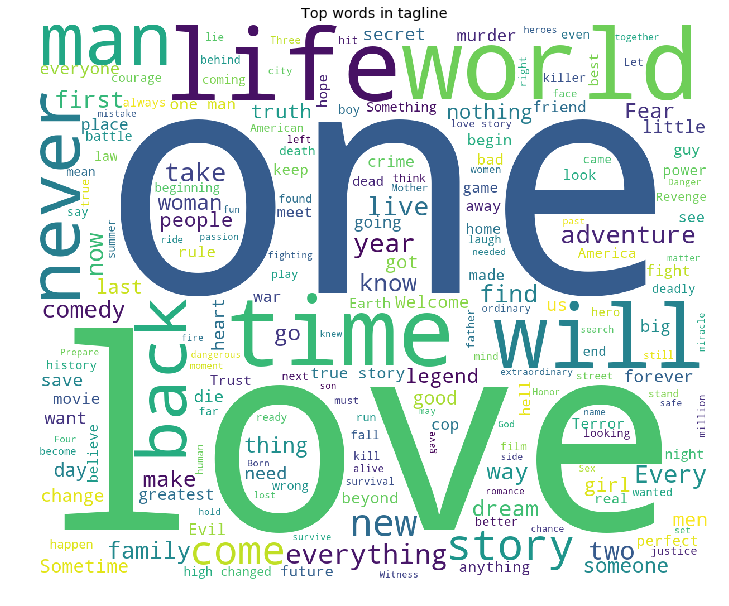

In [86]:
plt.figure(figsize = (12, 12))
text = ' '.join(df_train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

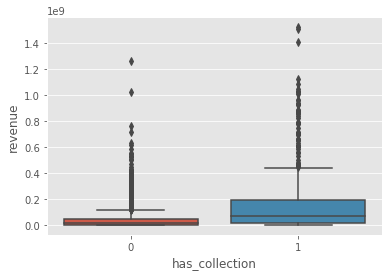

In [87]:
sns.boxplot(x='has_collection', y='revenue', data=df_train);


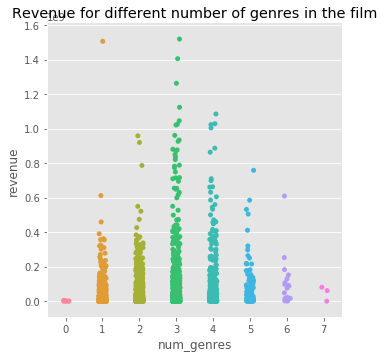

In [88]:
sns.catplot(x='num_genres', y='revenue', data=df_train);
plt.title('Revenue for different number of genres in the film');

/anaconda3/envs/mlpy36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



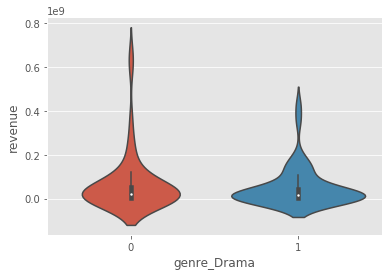

In [90]:
sns.violinplot(x='genre_Drama', y='revenue', data=df_train[:100]);

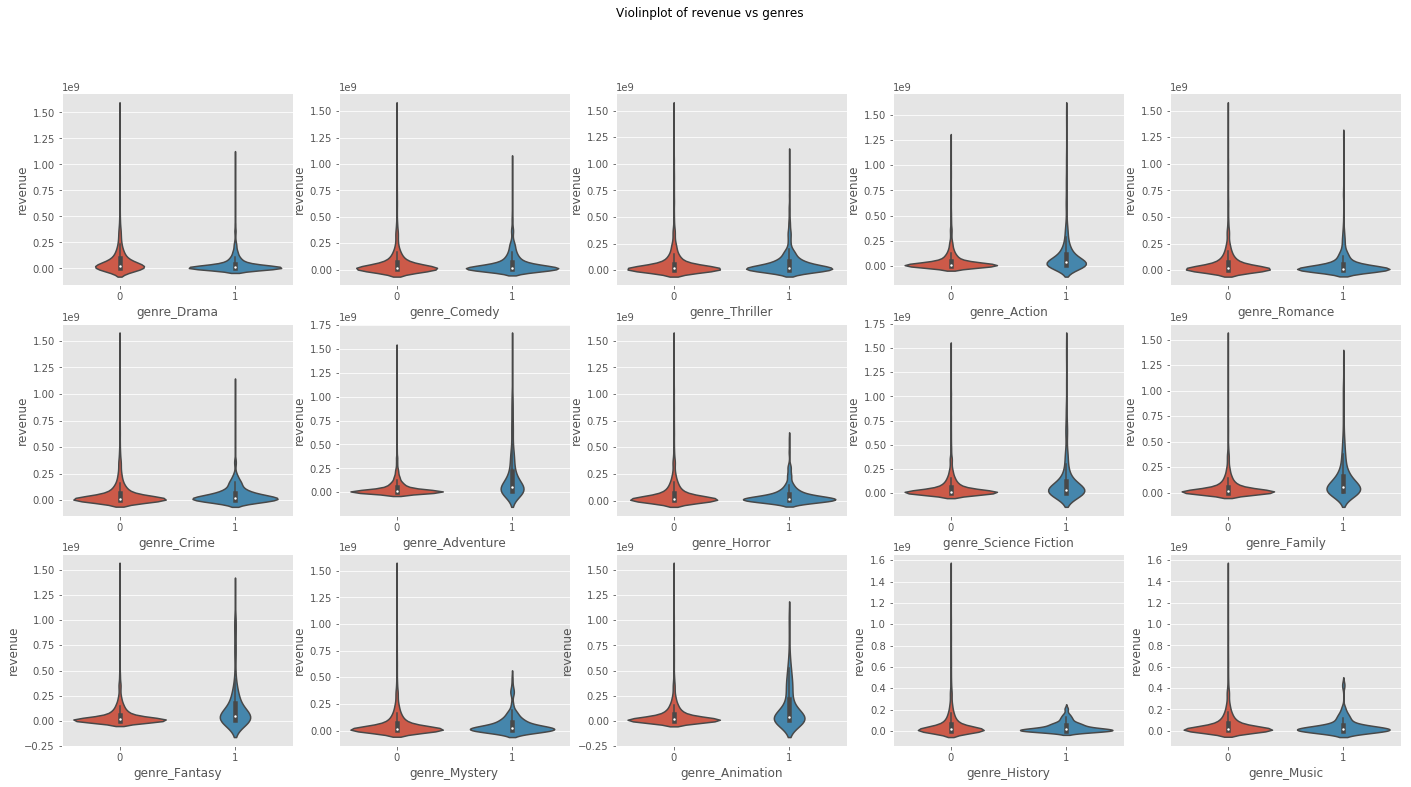

In [93]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in df_train.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=df_train, ax=axes[i // 5][i % 5]);

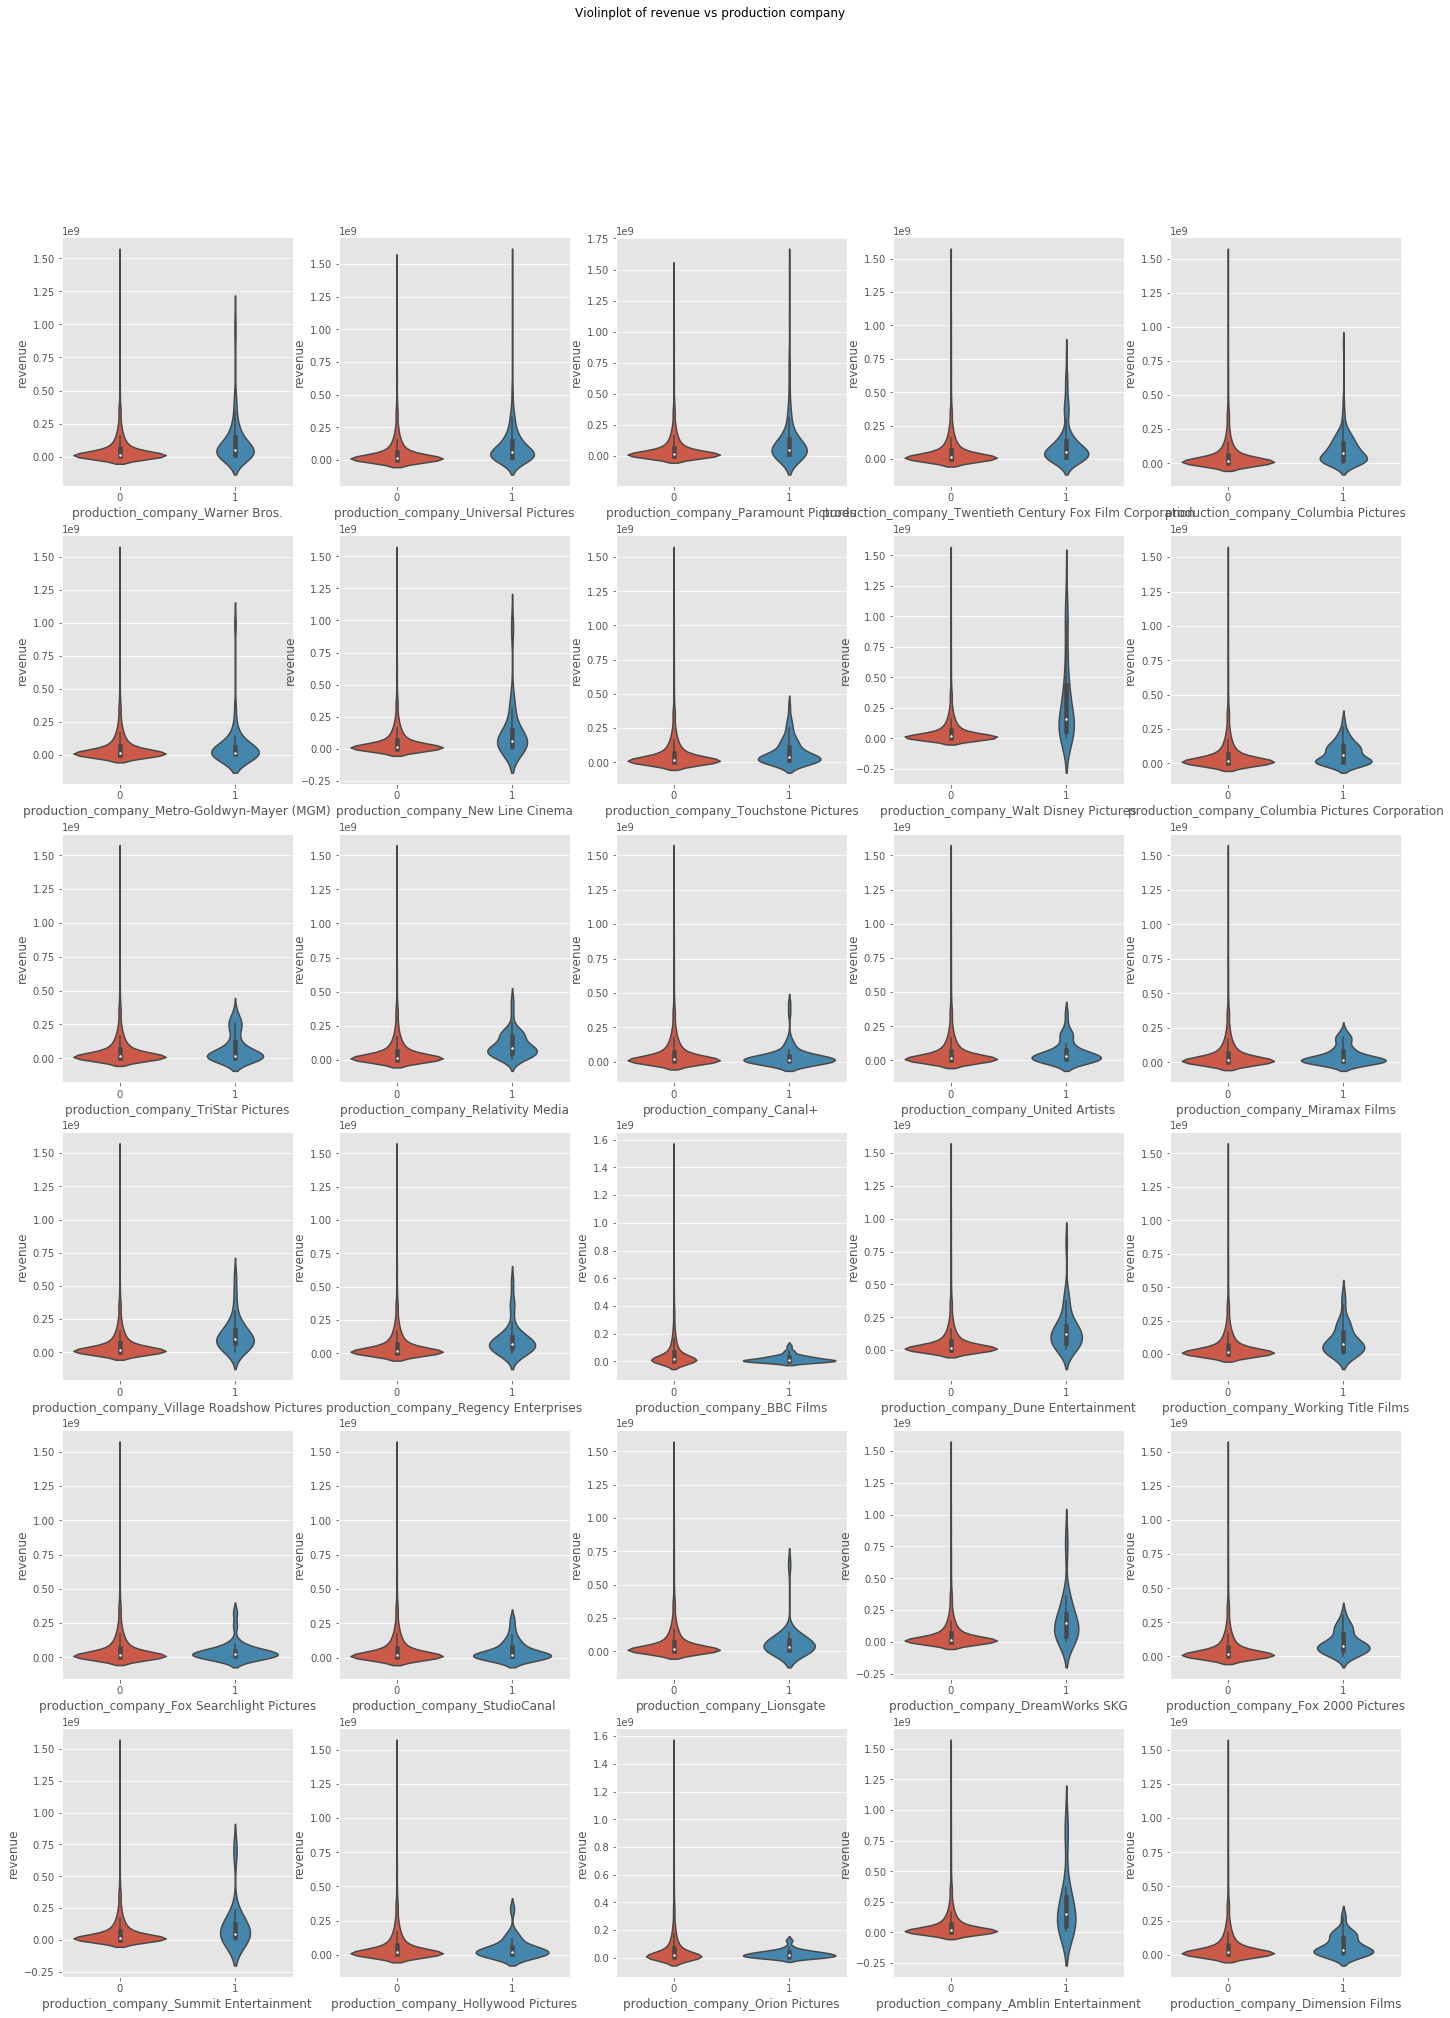

In [95]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in df_train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=df_train, ax=axes[i // 5][i % 5]);


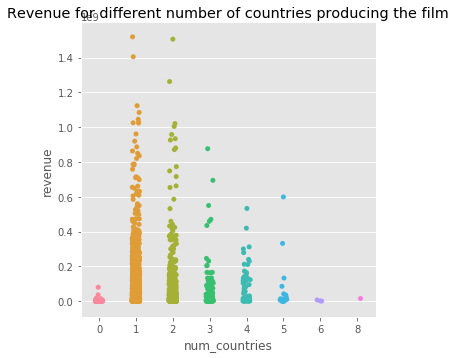

In [96]:
sns.catplot(x='num_countries', y='revenue', data=df_train);
plt.title('Revenue for different number of countries producing the film');

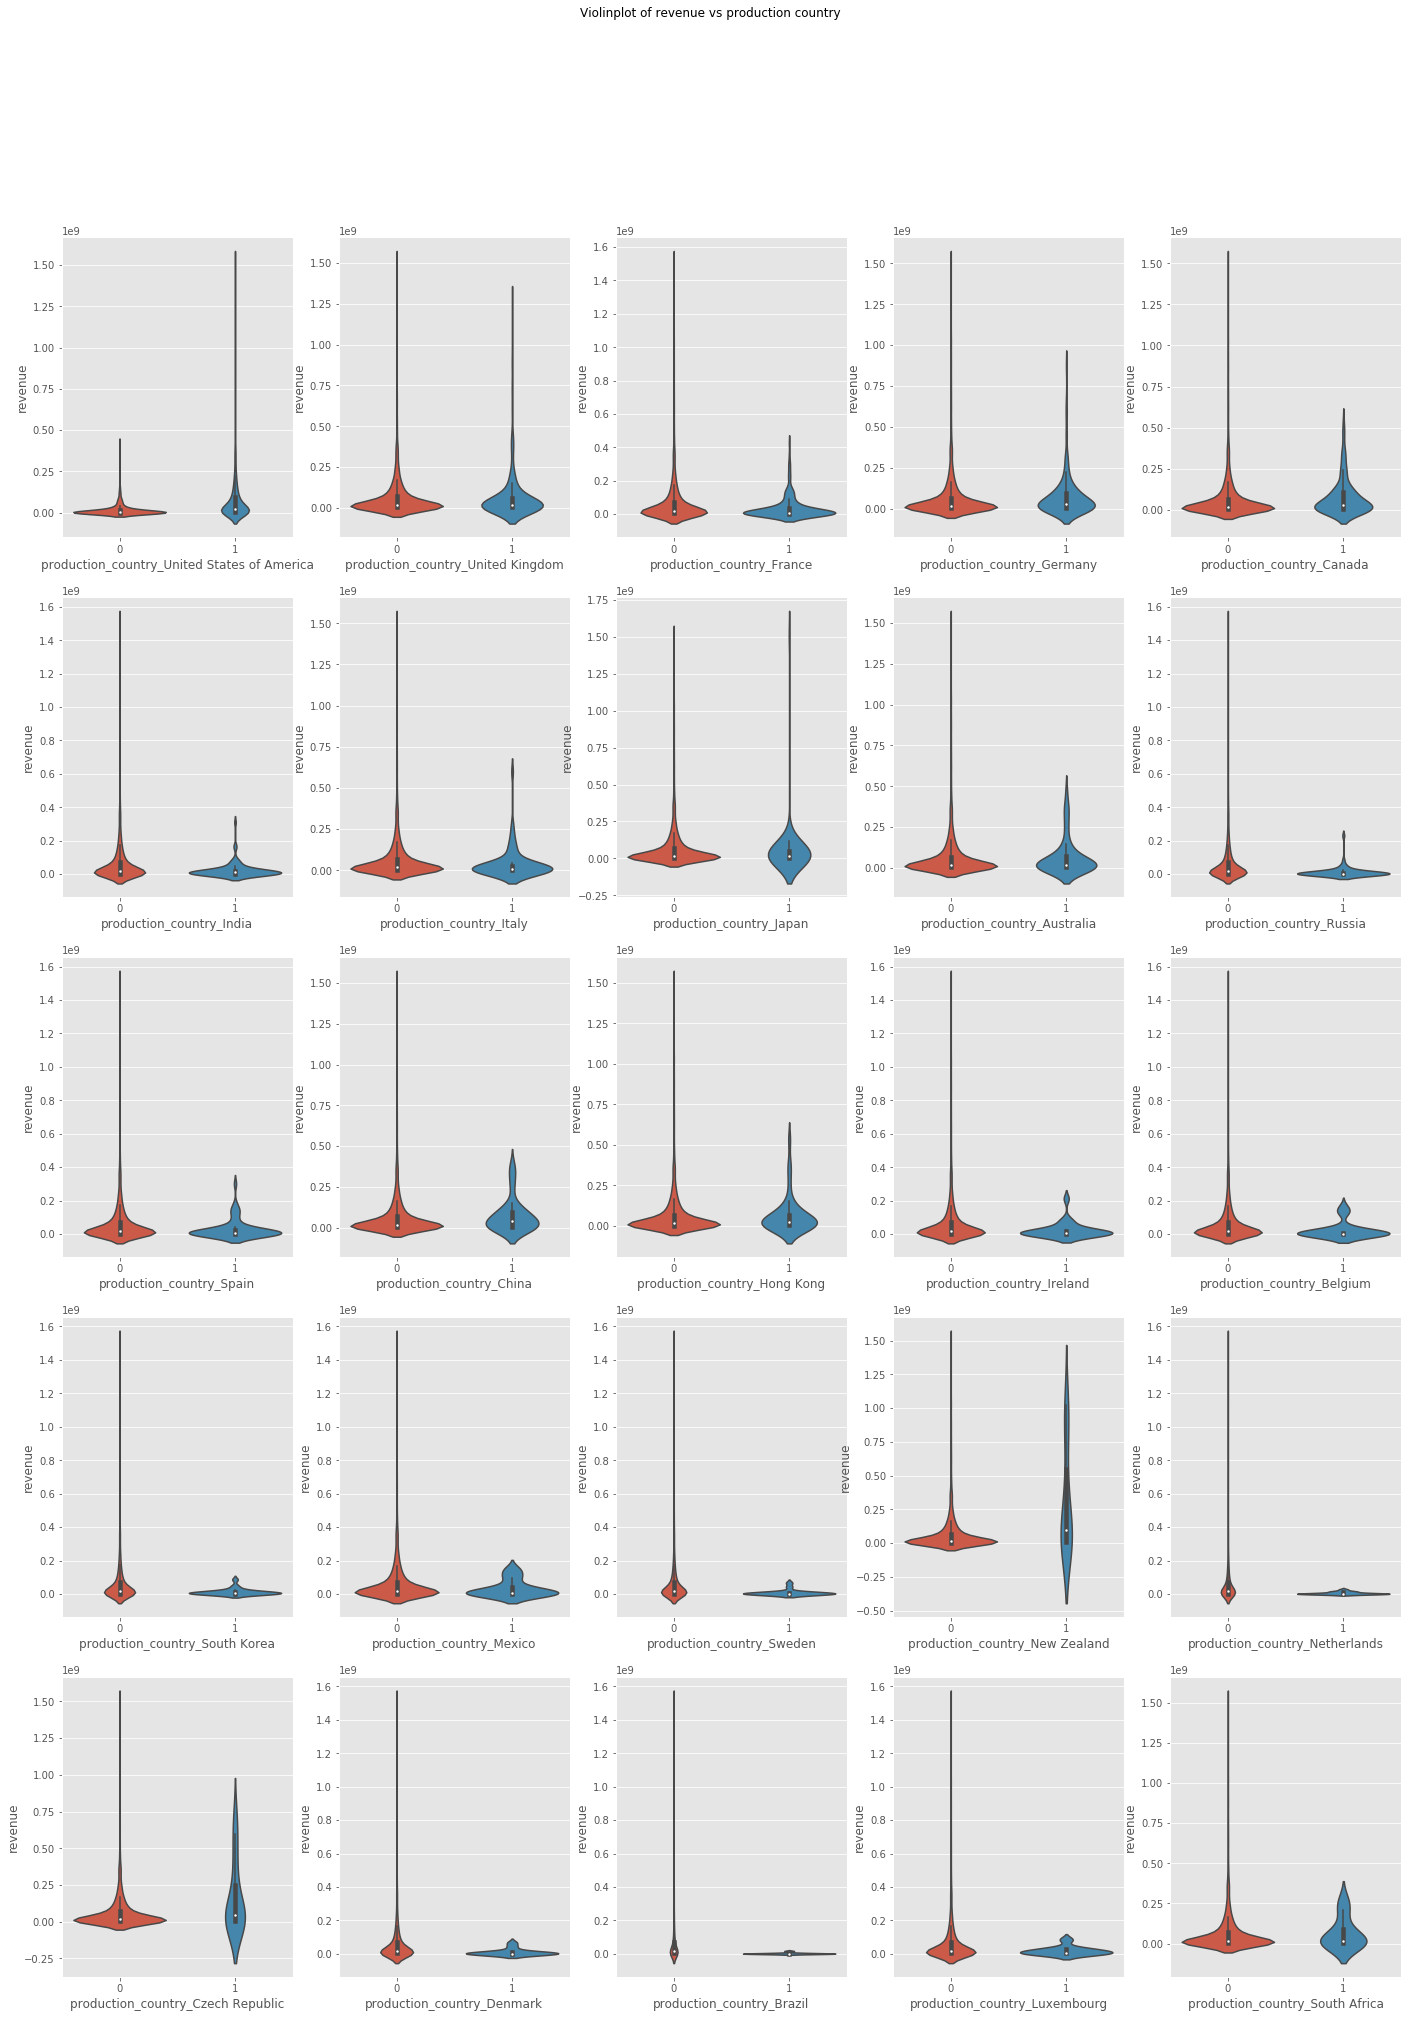

In [97]:
f, axes = plt.subplots(5, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in df_train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=df_train, ax=axes[i // 5][i % 5]);

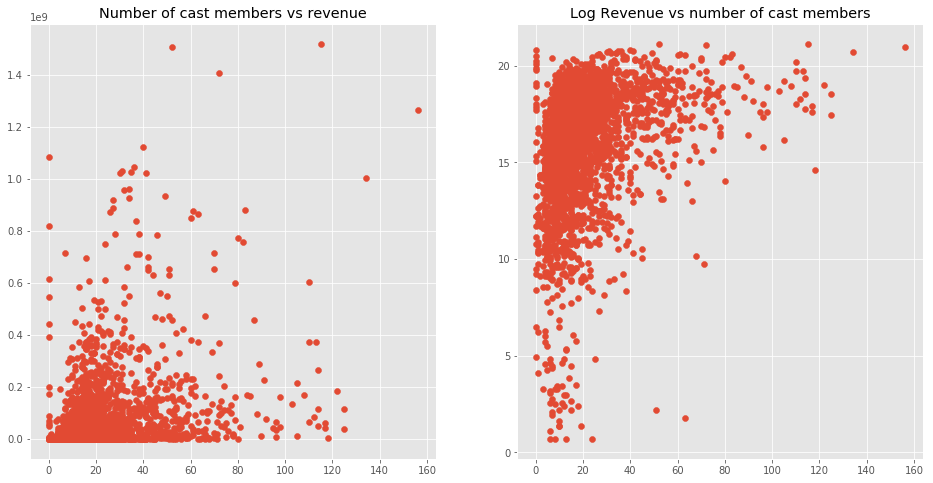

In [98]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(df_train['num_cast'], df_train['revenue'])
plt.title('Number of cast members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(df_train['num_cast'], df_train['log_revenue'])
plt.title('Log Revenue vs number of cast members');

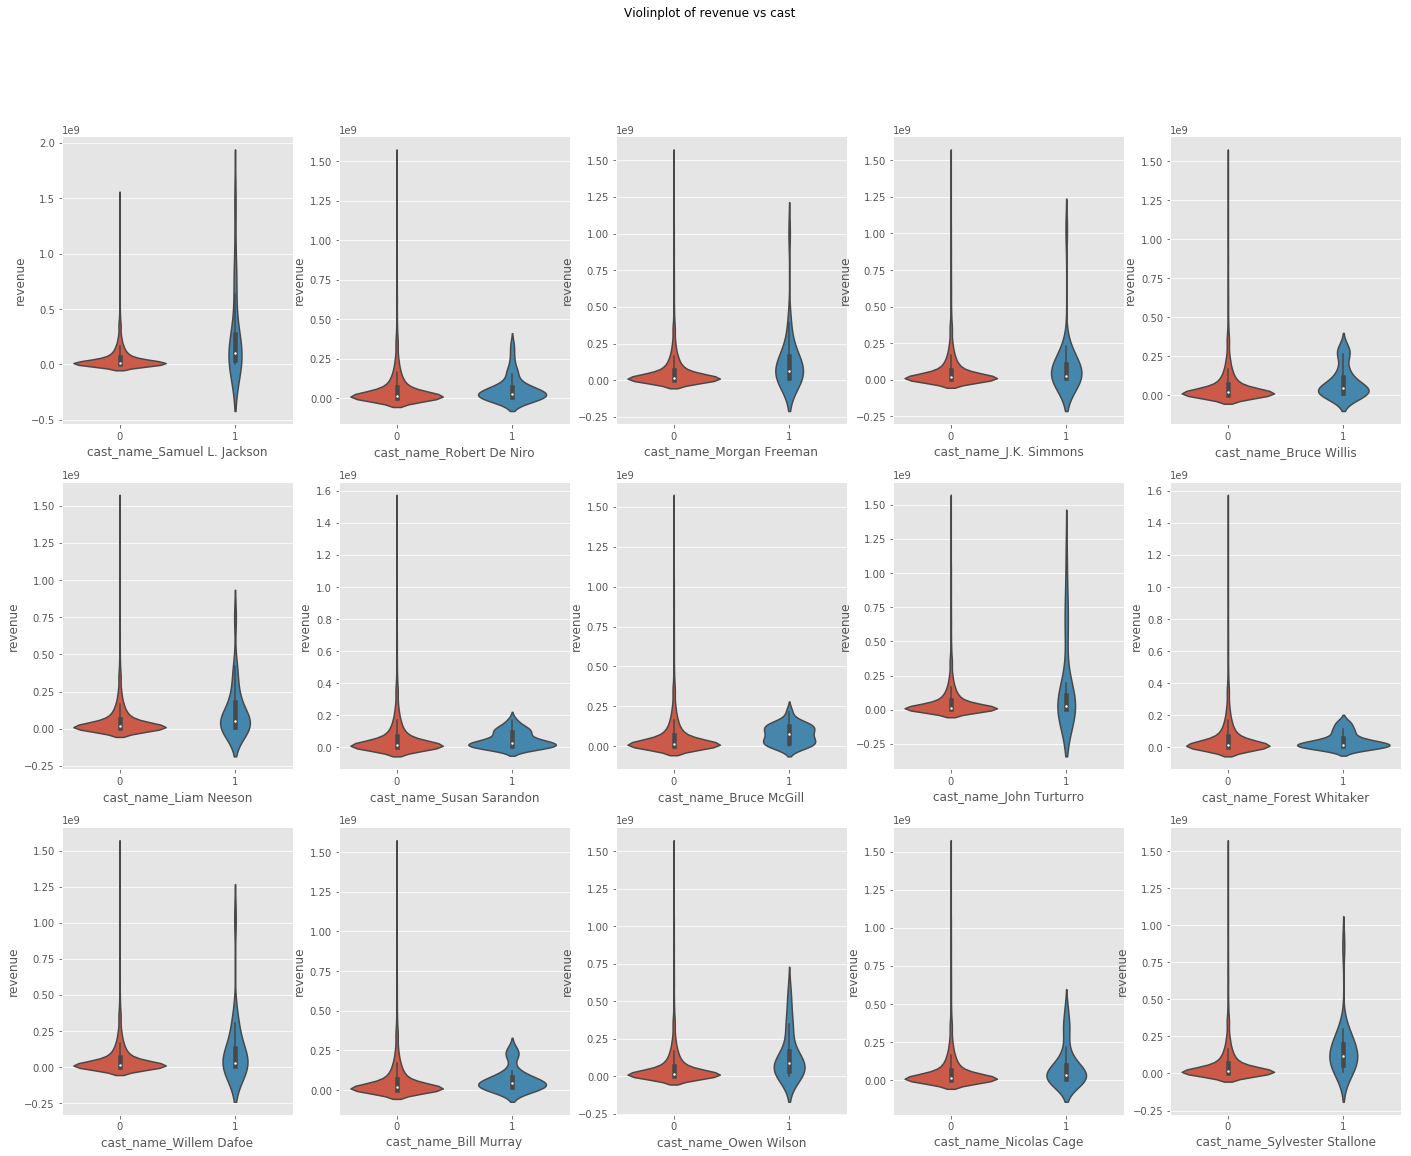

In [99]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in df_train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=df_train, ax=axes[i // 5][i % 5]);

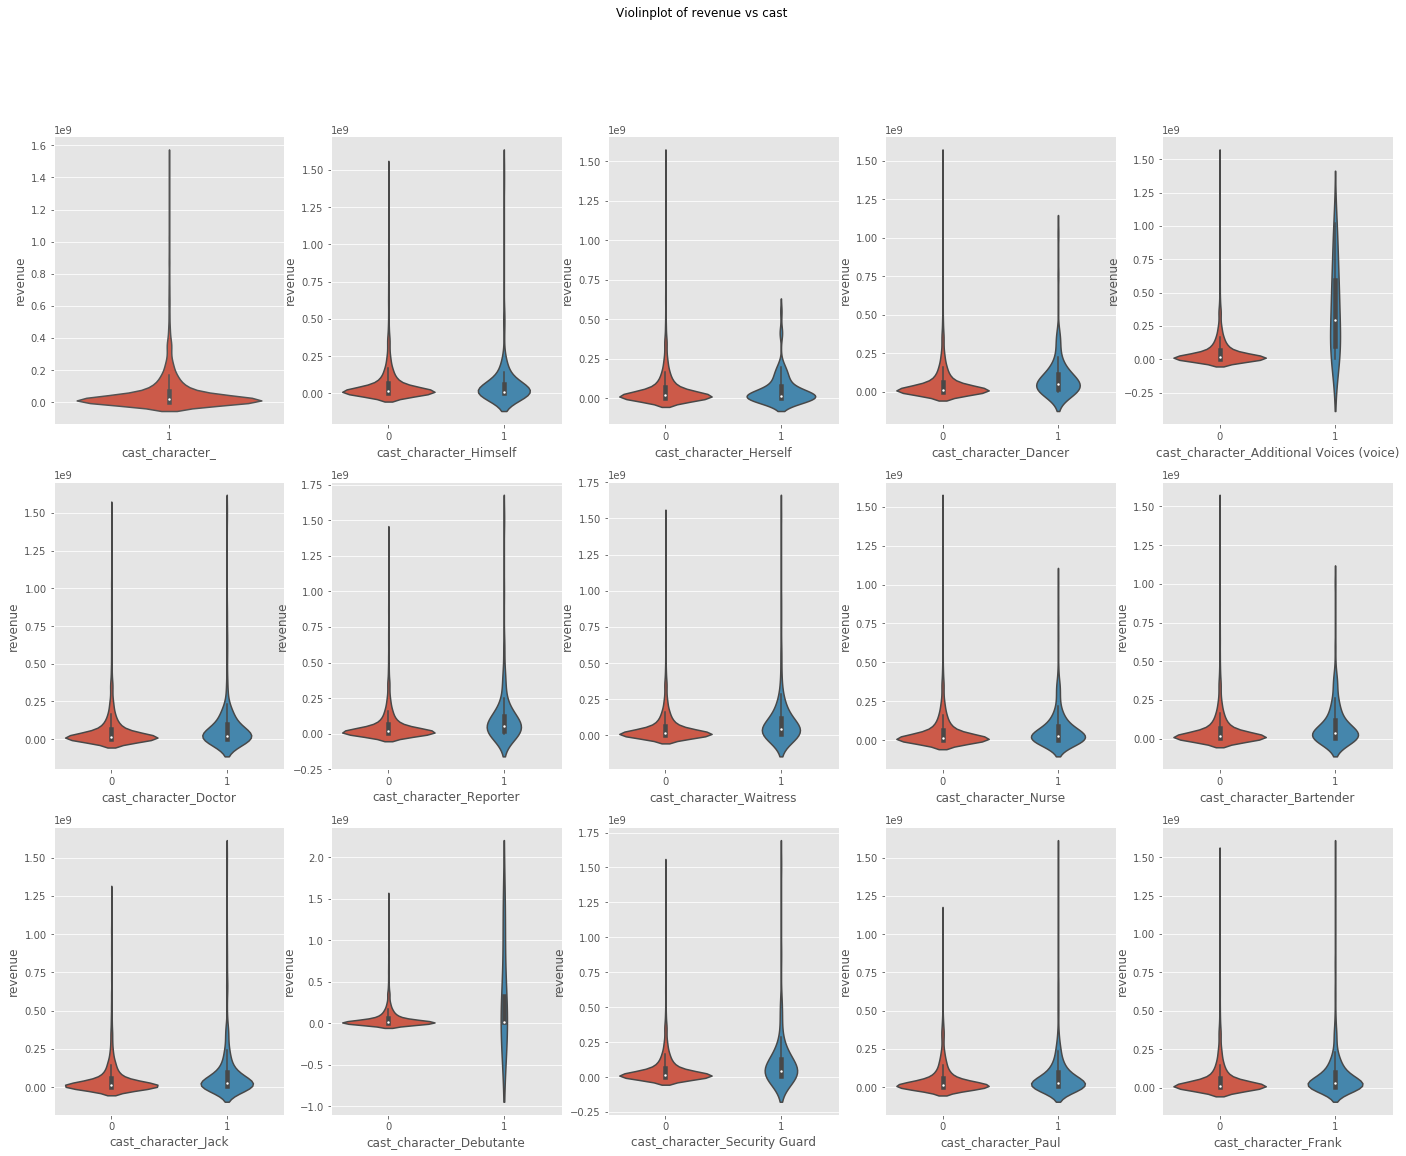

In [100]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in df_train.columns if 'cast_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=df_train, ax=axes[i // 5][i % 5]);

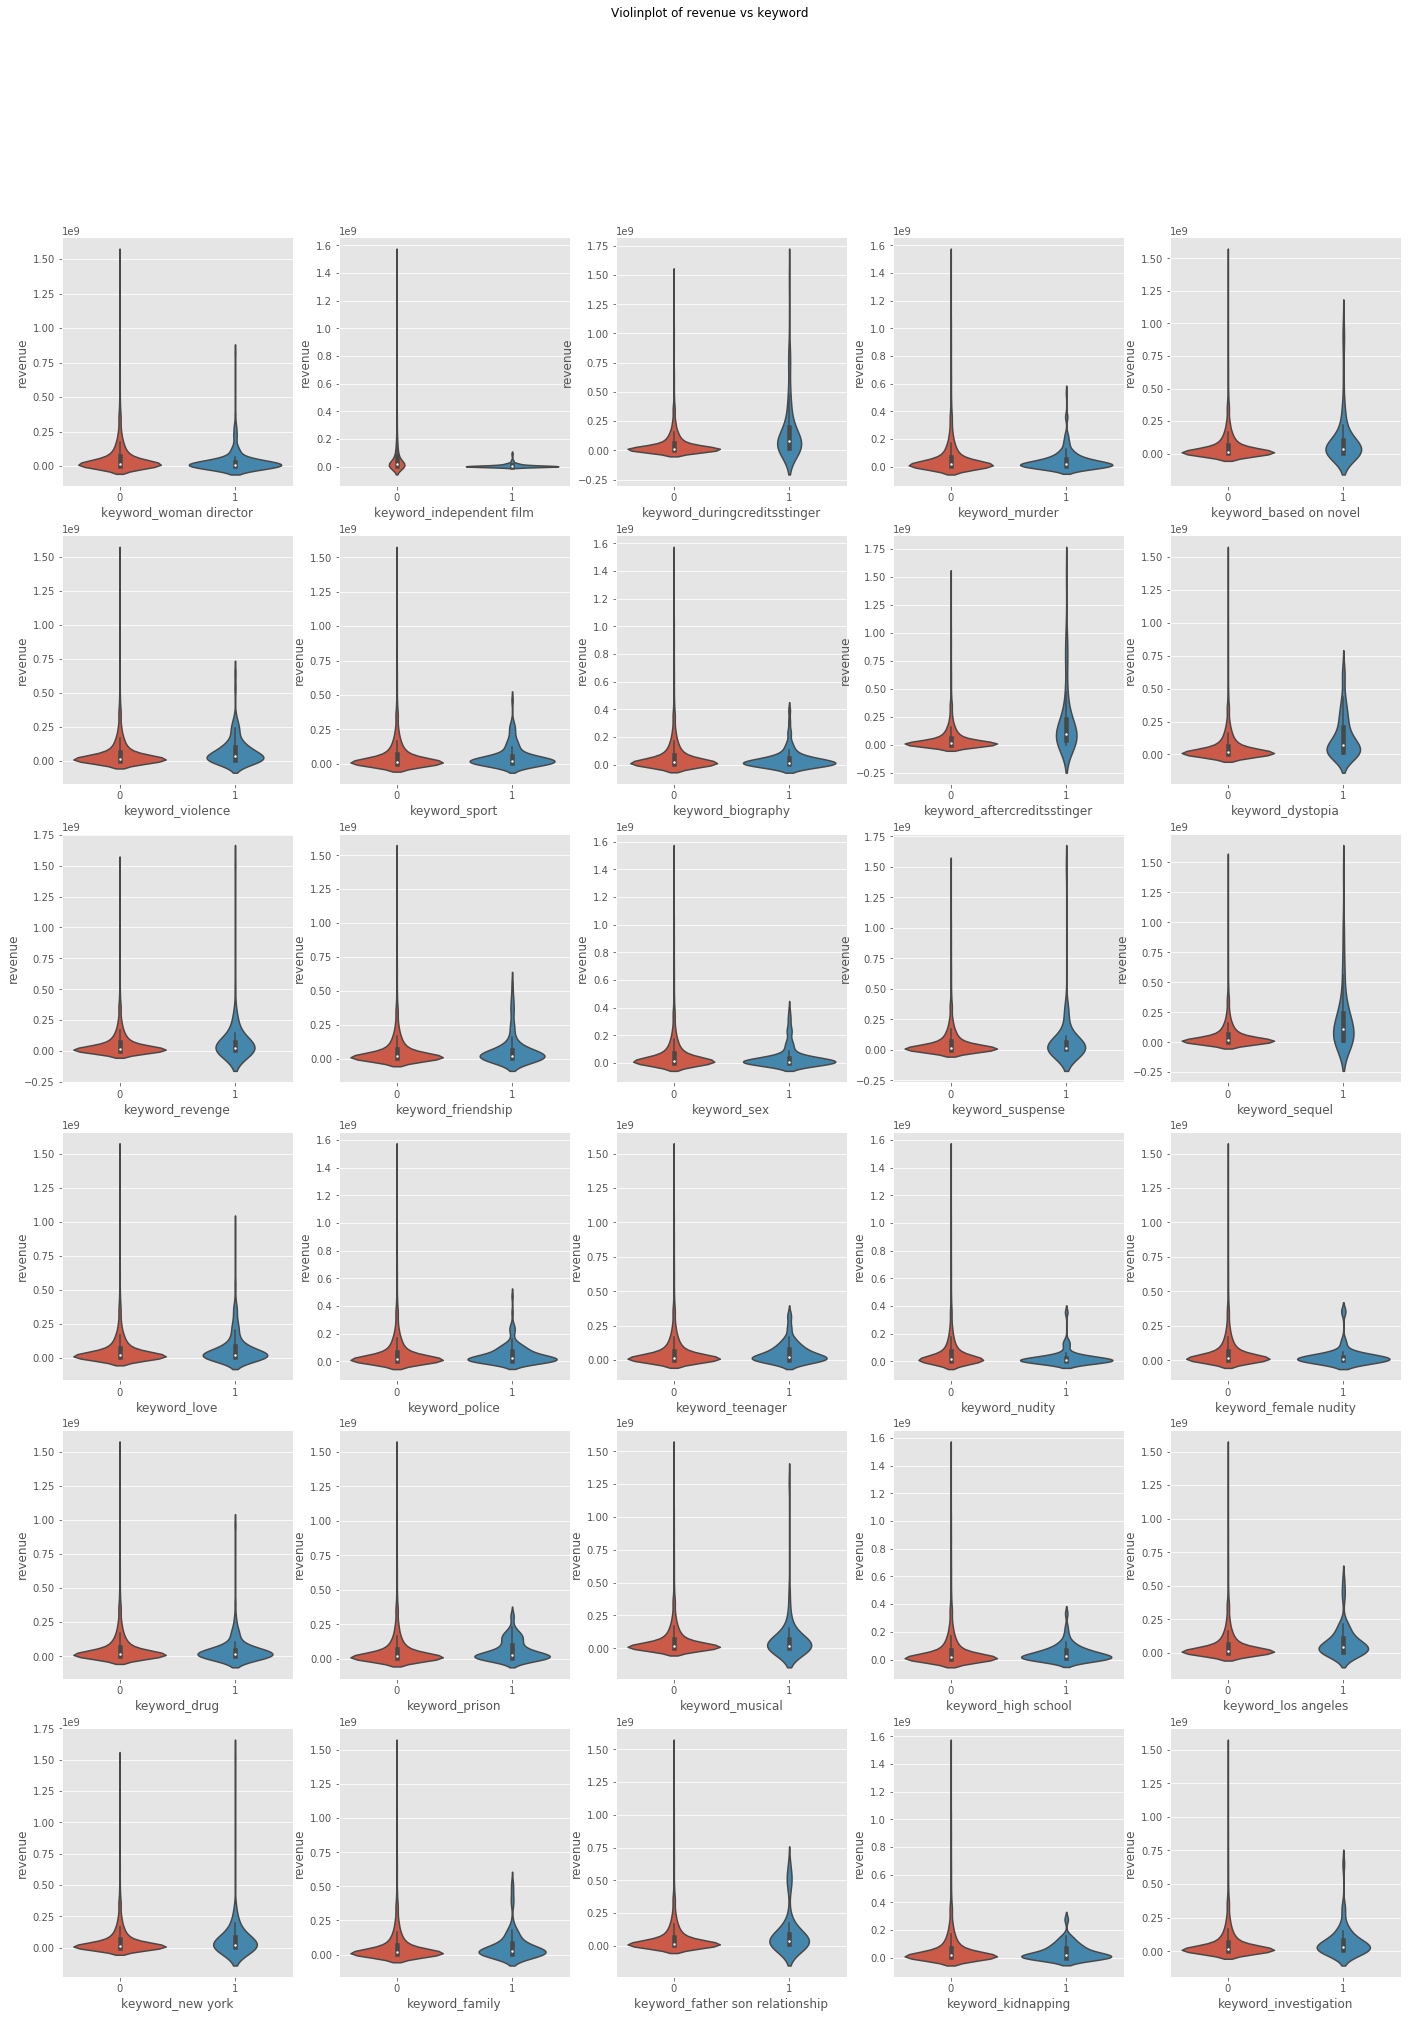

In [101]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in df_train.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=df_train, ax=axes[i // 5][i % 5]);

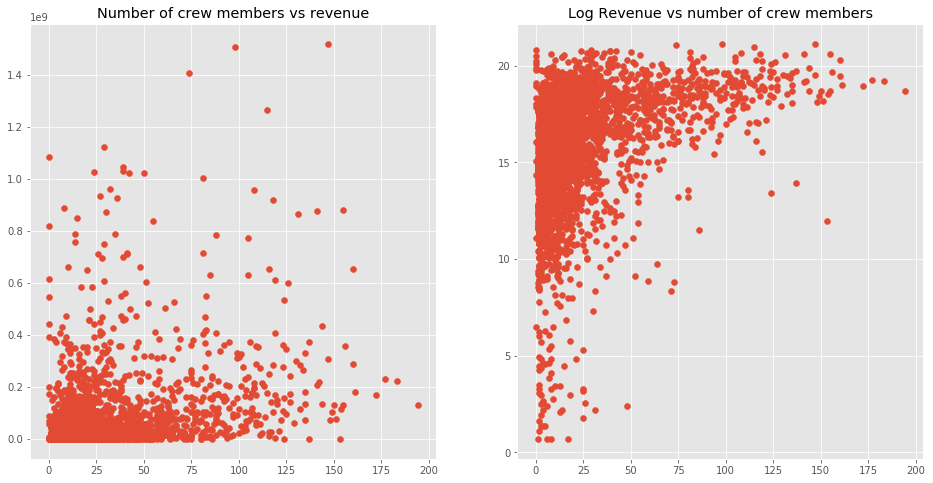

In [103]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(df_train['num_crew'], df_train['revenue'])
plt.title('Number of crew members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(df_train['num_crew'], df_train['log_revenue'])
plt.title('Log Revenue vs number of crew members');

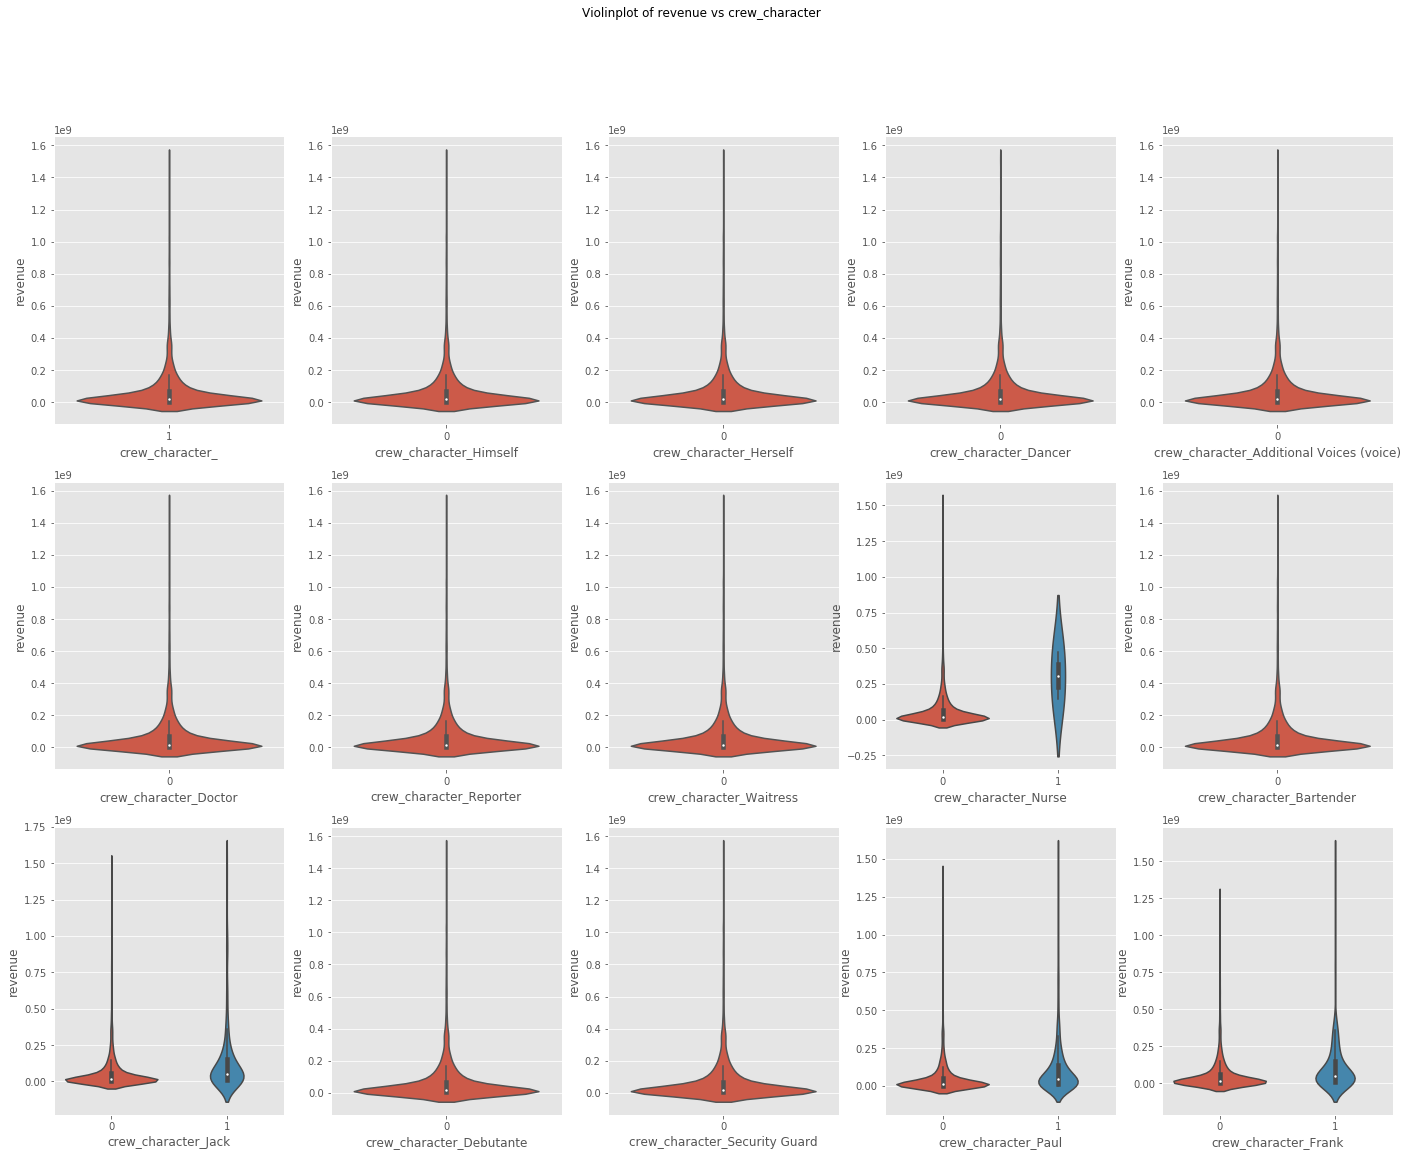

In [104]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs crew_character')
for i, e in enumerate([col for col in df_train.columns if 'crew_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=df_train, ax=axes[i // 5][i % 5]);

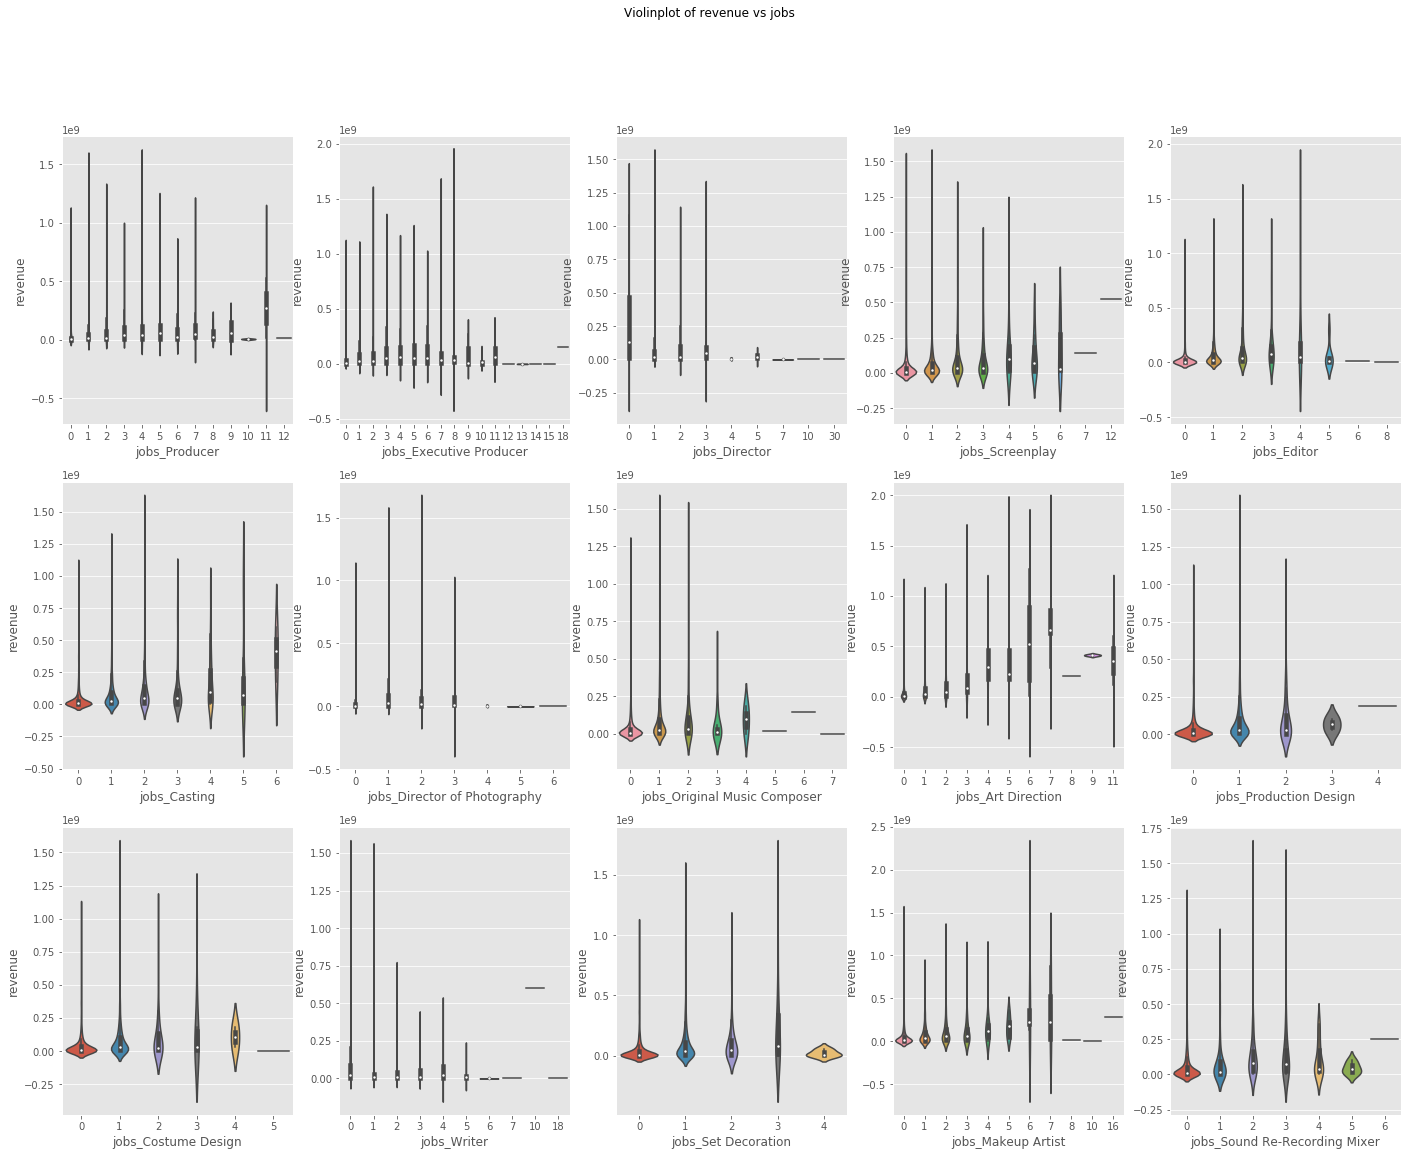

In [105]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in df_train.columns if 'jobs_' in col]):
    sns.violinplot(x=e, y='revenue', data=df_train, ax=axes[i // 5][i % 5]);

In [106]:
df_train = df_train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
df_test = df_test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [108]:
for col in df_train.columns:
    if df_train[col].nunique() == 1:
        print(col)
        df_train = df_train.drop([col], axis=1)
        df_test = df_test.drop([col], axis=1)

language_
cast_character_
crew_character_
crew_character_Himself
crew_character_Herself
crew_character_Dancer
crew_character_Additional Voices (voice)
crew_character_Doctor
crew_character_Reporter
crew_character_Waitress
crew_character_Bartender
crew_character_Debutante
crew_character_Security Guard


In [109]:
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(df_train[col].fillna('')) + list(df_test[col].fillna('')))
    df_train[col] = le.transform(df_train[col].fillna('').astype(str))
    df_test[col] = le.transform(df_test[col].fillna('').astype(str))

In [110]:
df_train_texts = df_train[['title', 'tagline', 'overview', 'original_title']]
df_test_texts = df_test[['title', 'tagline', 'overview', 'original_title']]

In [111]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    df_train['len_' + col] = df_train[col].fillna('').apply(lambda x: len(str(x)))
    df_train['words_' + col] = df_train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    df_train = df_train.drop(col, axis=1)
    df_test['len_' + col] = df_test[col].fillna('').apply(lambda x: len(str(x)))
    df_test['words_' + col] = df_test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    df_test = df_test.drop(col, axis=1)

In [112]:
X = df_train.drop(['id', 'revenue'], axis=1)
y = np.log1p(df_train['revenue'])
X_test = df_test.drop(['id'], axis=1)

In [113]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [114]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[374]	training's rmse: 1.70537	valid_1's rmse: 2.02633


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.9, importance_type='split',
       lambda_l1=0.2, learning_rate=0.01, max_depth=5, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
       min_split_gain=0.0, n_estimators=20000, n_jobs=-1, nthread=4,
       num_leaves=30, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [115]:
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

In [116]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [117]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Sun Feb 17 15:58:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 1.37512	valid_1's rmse: 2.00755
Early stopping, best iteration is:
[1110]	valid_0's rmse: 1.33266	valid_1's rmse: 2.00344
Fold 1 started at Sun Feb 17 15:58:32 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 1.40273	valid_1's rmse: 1.94487
Early stopping, best iteration is:
[1208]	valid_0's rmse: 1.32156	valid_1's rmse: 1.94321
Fold 2 started at Sun Feb 17 15:58:34 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 1.38001	valid_1's rmse: 2.01571
Early stopping, best iteration is:
[1207]	valid_0's rmse: 1.29975	valid_1's rmse: 2.01002
Fold 3 started at Sun Feb 17 15:58:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 1.32779	valid_1's rmse: 2.37439
Early stopping, best iteration is:
[1647]	valid_0's rmse: 1.11344	valid_1's rmse: 2.36

/anaconda3/envs/mlpy36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



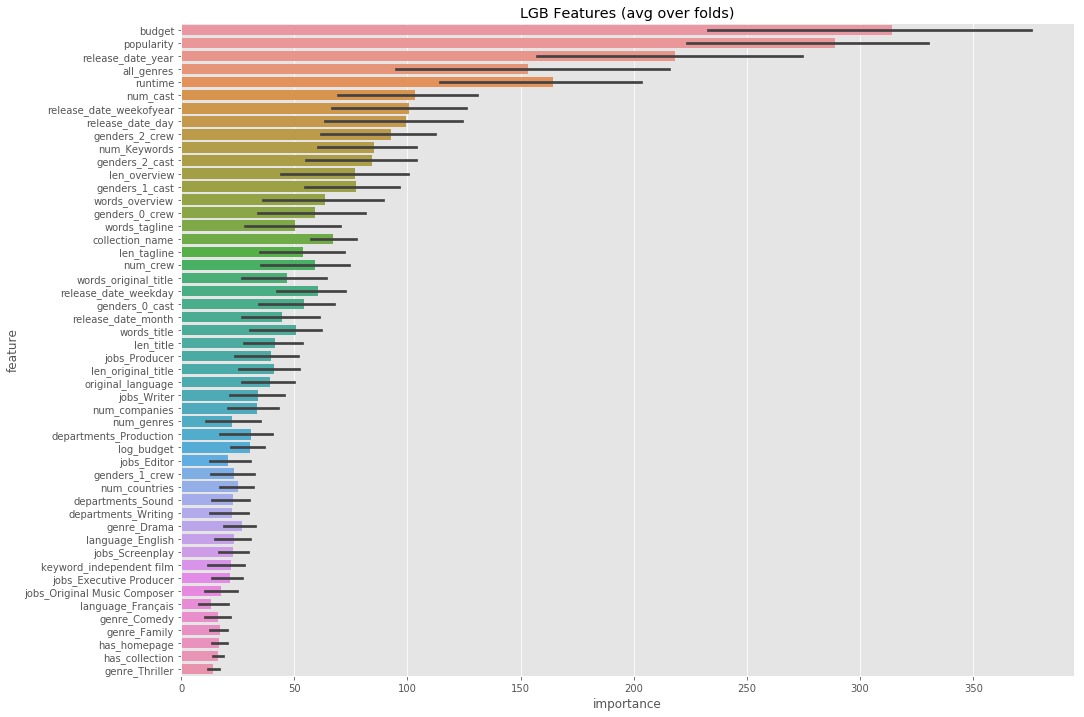

In [118]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

In [123]:
for col in df_train_texts.columns:
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=5
    )
    vectorizer.fit(list(df_train_texts[col].fillna('')) + list(df_test_texts[col].fillna('')))
    train_col_text = vectorizer.transform(df_train_texts[col].fillna(''))
    test_col_text = vectorizer.transform(df_test_texts[col].fillna(''))
    model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
    oof_text, prediction_text = train_model(train_col_text, test_col_text, y, params=None, model_type='sklearn', model=model)
    
    X[col + '_oof'] = oof_text
    X_test[col + '_oof'] = prediction_text

Fold 0 started at Sun Feb 17 16:01:50 2019
Fold 1 started at Sun Feb 17 16:01:50 2019
Fold 2 started at Sun Feb 17 16:01:51 2019
Fold 3 started at Sun Feb 17 16:01:51 2019
Fold 4 started at Sun Feb 17 16:01:51 2019
CV mean score: 3.0279, std: 0.1729.
Fold 0 started at Sun Feb 17 16:01:52 2019
Fold 1 started at Sun Feb 17 16:01:53 2019
Fold 2 started at Sun Feb 17 16:01:53 2019
Fold 3 started at Sun Feb 17 16:01:54 2019
Fold 4 started at Sun Feb 17 16:01:55 2019
CV mean score: 2.9731, std: 0.1451.
Fold 0 started at Sun Feb 17 16:01:57 2019
Fold 1 started at Sun Feb 17 16:01:59 2019
Fold 2 started at Sun Feb 17 16:02:02 2019
Fold 3 started at Sun Feb 17 16:02:05 2019
Fold 4 started at Sun Feb 17 16:02:06 2019
CV mean score: 2.9807, std: 0.1625.
Fold 0 started at Sun Feb 17 16:02:09 2019
Fold 1 started at Sun Feb 17 16:02:09 2019
Fold 2 started at Sun Feb 17 16:02:10 2019
Fold 3 started at Sun Feb 17 16:02:10 2019
Fold 4 started at Sun Feb 17 16:02:10 2019
CV mean score: 3.0220, std: 0.17

In [124]:
X.head()

budget  original_language  popularity  runtime  collection_name  \
0  14000000                 10    6.575393     93.0              282   
1  40000000                 10    8.248895    113.0              641   
2   3300000                 10   64.299990    105.0                1   
3   1200000                 16    3.174936    122.0                1   
4         0                 24    1.148070    118.0                1   

   has_collection  num_genres  all_genres  genre_Drama  genre_Comedy  \
0               1           1         480            0             1   
1               1           4         516            1             1   
2               0           1         658            1             0   
3               0           2         742            1             0   
4               0           2         295            0             0   

   genre_Thriller  genre_Action  genre_Romance  genre_Crime  genre_Adventure  \
0               0             0              0            0                0   
1               0             0              1            0                0   
2               0             0              0            0                0   
3               1             0              0            0                0   
4               1             1              0            0                0   

   genre_Horror  genre_Science Fiction  genre_Family  genre_Fantasy  \
0             0                      0             0              0   
1             0                      0             1              0   
2             0                      0             0              0   
3             0                      0             0              0   
4             0                      0             0              0   

   genre_Mystery  genre_Animation  genre_History  genre_Music  num_companies  \
0              0                0              0            0              3   
1              0                0              0            0              1   
2              0                0              0            0              3   
3              0                0              0            0              0   
4              0                0              0            0              0   

   production_company_Warner Bros.  production_company_Universal Pictures  \
0                                0                                      0   
1                                0                                      0   
2                                0                                      0   
3                                0                                      0   
4                                0                                      0   

   production_company_Paramount Pictures  \
0                                      1   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   production_company_Twentieth Century Fox Film Corporation  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   production_company_Columbia Pictures  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   production_company_Metro-Goldwyn-Mayer (MGM)  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   production_company_New Line Cinema  production_company_Touchstone Pi

In [125]:
def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')
        
    return df

In [126]:
X = new_features(X)
X_test = new_features(X_test)

Fold 0 started at Sun Feb 17 16:03:26 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 1.32733	valid_1's rmse: 1.99855
Early stopping, best iteration is:
[1093]	valid_0's rmse: 1.28933	valid_1's rmse: 1.99684
Fold 1 started at Sun Feb 17 16:03:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 1.31758	valid_1's rmse: 1.92736
Early stopping, best iteration is:
[1021]	valid_0's rmse: 1.30735	valid_1's rmse: 1.92668
Fold 2 started at Sun Feb 17 16:03:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 1.311	valid_1's rmse: 1.98499
Early stopping, best iteration is:
[1644]	valid_0's rmse: 1.0692	valid_1's rmse: 1.9756
Fold 3 started at Sun Feb 17 16:03:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[611]	valid_0's rmse: 1.41052	valid_1's rmse: 2.39327
Fold 4 started at Sun Feb 17 16:03:36 2019
Training unti

/anaconda3/envs/mlpy36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



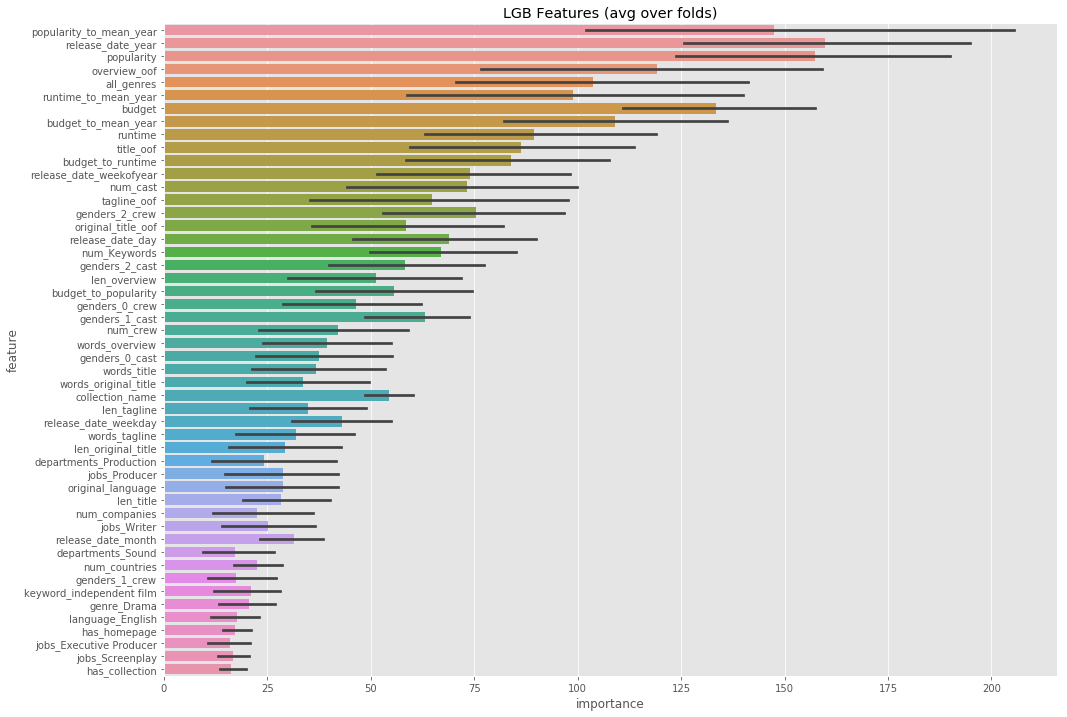

In [127]:
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[401]	training's rmse: 1.45937	valid_1's rmse: 1.94862


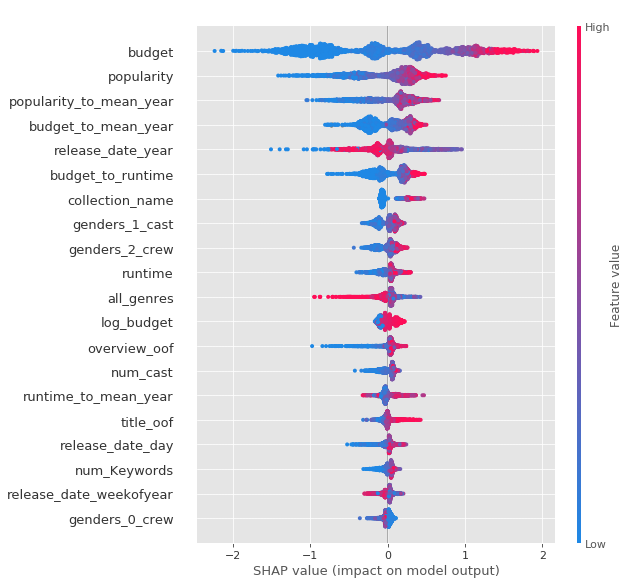

In [129]:
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

/anaconda3/envs/mlpy36/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



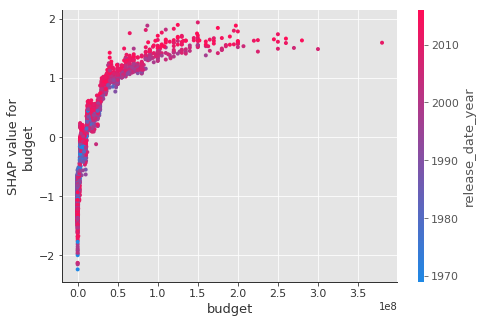

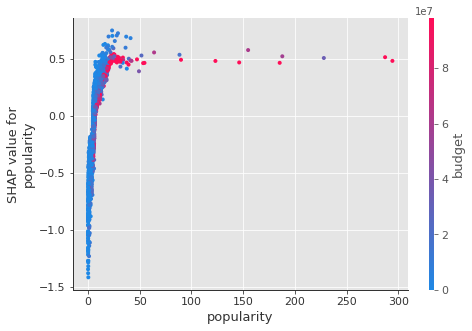

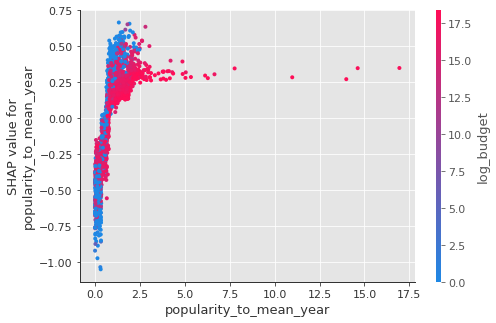

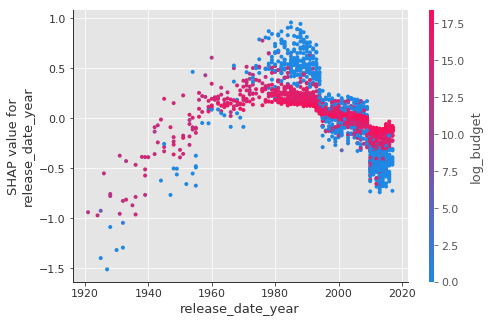

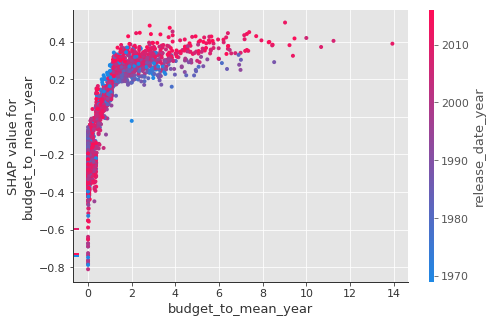

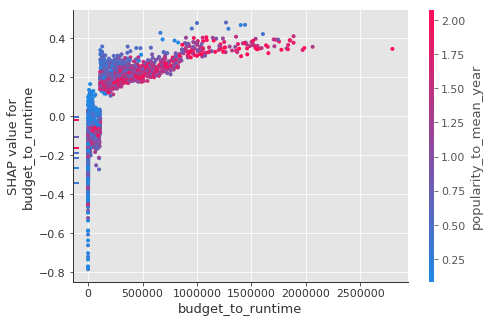

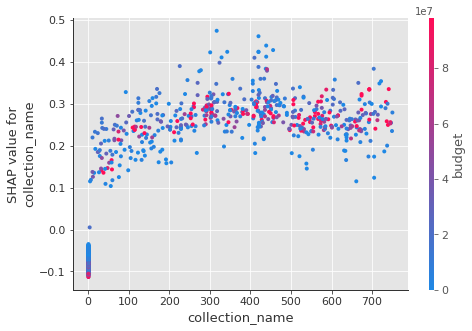

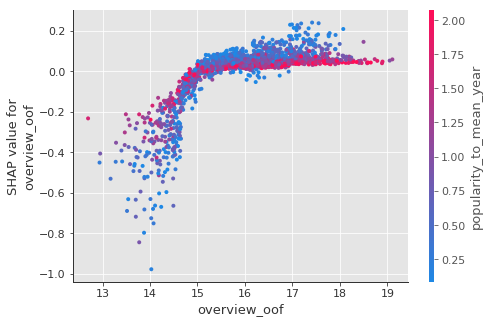

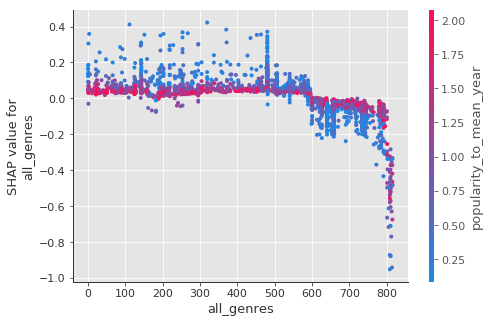

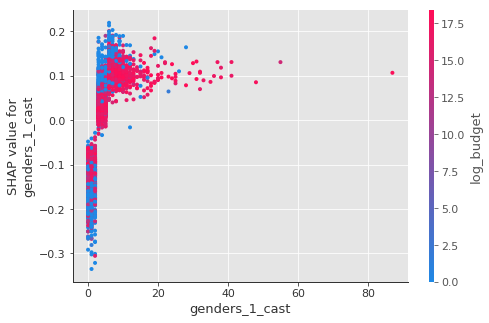

In [130]:
top_cols = X_train.columns[np.argsort(shap_values.std(0))[::-1]][:10]
for col in top_cols:
    shap.dependence_plot(col, shap_values, X_train)

In [131]:
def top_cols_interaction(df):
    df['budget_to_year'] = df['budget'] / df['release_date_year']
    df['budget_to_mean_year_to_year'] = df['budget_to_mean_year'] / df['release_date_year']
    df['popularity_to_mean_year_to_log_budget'] = df['popularity_to_mean_year'] / df['log_budget']
    df['year_to_log_budget'] = df['release_date_year'] / df['log_budget']
    df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_year']
    df['genders_1_cast_to_log_budget'] = df['genders_1_cast'] / df['log_budget']
    df['all_genres_to_popularity_to_mean_year'] = df['all_genres'] / df['popularity_to_mean_year']
    df['genders_2_crew_to_budget_to_mean_year'] = df['genders_2_crew'] / df['budget_to_mean_year']
    df['overview_oof_to_genders_2_crew'] = df['overview_oof'] / df['genders_2_crew']
    
    return df

In [132]:
X = top_cols_interaction(X)
X_test = top_cols_interaction(X_test)

Fold 0 started at Sun Feb 17 16:05:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[670]	valid_0's rmse: 1.20005	valid_1's rmse: 1.9914
Fold 1 started at Sun Feb 17 16:05:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[485]	valid_0's rmse: 1.34749	valid_1's rmse: 1.92622
Fold 2 started at Sun Feb 17 16:05:17 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 0.98073	valid_1's rmse: 1.99144
Early stopping, best iteration is:
[1211]	valid_0's rmse: 0.873739	valid_1's rmse: 1.98965
Fold 3 started at Sun Feb 17 16:05:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[674]	valid_0's rmse: 1.12246	valid_1's rmse: 2.41623
Fold 4 started at Sun Feb 17 16:05:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	valid_0's rmse: 1

/anaconda3/envs/mlpy36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



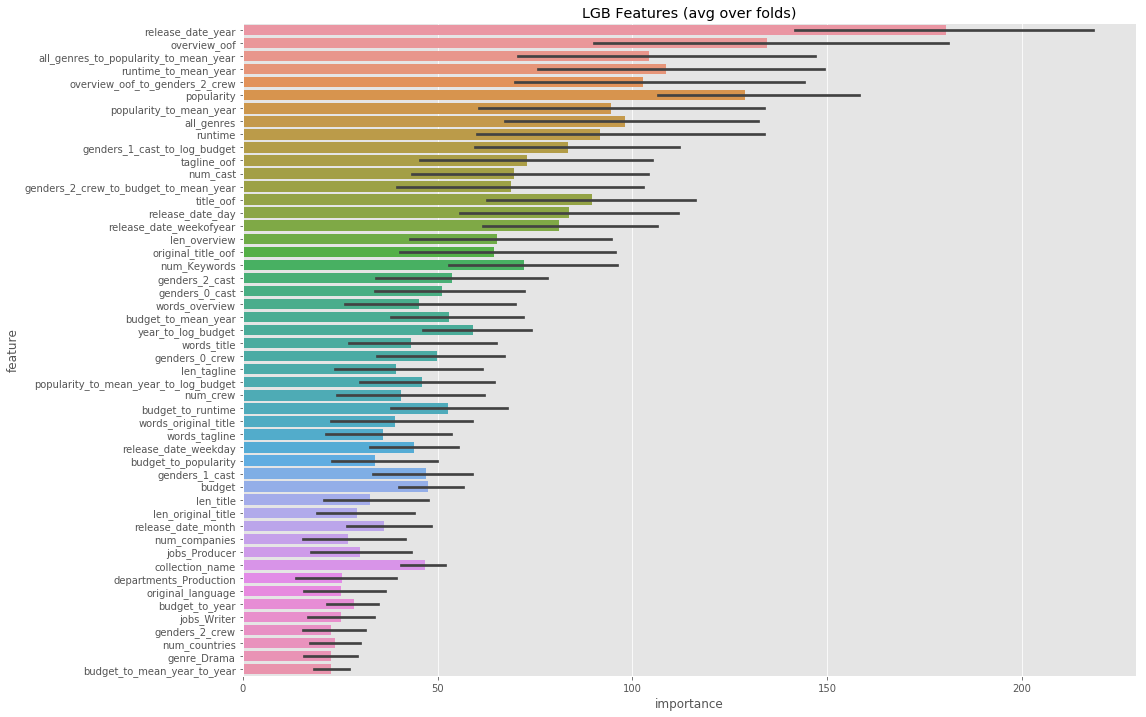

In [133]:
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

In [134]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 5,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb, prediction_xgb = train_model(X, X_test, y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Feb 17 16:05:47 2019
[0]	train-rmse:15.5733	valid_data-rmse:15.7479
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.36435	valid_data-rmse:2.00298
[1000]	train-rmse:1.04187	valid_data-rmse:1.96785
[1500]	train-rmse:0.818623	valid_data-rmse:1.96137
[2000]	train-rmse:0.652445	valid_data-rmse:1.95605
[2500]	train-rmse:0.520008	valid_data-rmse:1.95275
Stopping. Best iteration:
[2410]	train-rmse:0.541739	valid_data-rmse:1.95227

Fold 1 started at Sun Feb 17 16:07:06 2019
[0]	train-rmse:15.6175	valid_data-rmse:15.5721
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.38068	valid_data-rmse:1.9665
[1000]	train-rmse:1.05156	valid_data-rmse:1.92141
[1500]	train-rmse:0.825863	valid_data-rmse:1.91296
[2000]	train-rmse:0.654238	va

In [135]:
sub = pd.read_csv('/Users/zakopuro/Code/python_code/kaggle_TMDB/input/sample_submission.csv')
sub['revenue'] = np.expm1(prediction_lgb)
sub.to_csv("output/lgb.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
sub.to_csv("output/blend.csv", index=False)